# 0.0. Imports

In [189]:
# Manipulacao
import pandas as pd
import numpy as np
import inflection
from unidecode import unidecode
import statistics
from scipy import stats as ss
import random
import pickle

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image


# Machine Learning
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection as ms
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model as lm
from sklearn import tree as tr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from boruta import BorutaPy

## 0.1. Helper Functions

In [175]:
def jupyter_settings():
    '''
    Faz algumas correcoes no notebook.
    '''
    %matplotlib inline
    
    pd.options.display.float_format = '{:20.3f}'.format
    pd.set_option('display.max_rows', 200)
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()
    
    
def fillout_reg(df):
    '''
    Funcao para fazer o fillout dos valores NaN usando um modelo de regressao.
    '''
    list_na = df.loc[:, df.isnull().sum() > 0].columns.to_list()
    
    columns_cat = df.select_dtypes(include='object').columns.to_list()
    
    dict_new_column = {}
    
    for value in columns_cat:
        if len(df[value].value_counts()) > 1:
            get_dum = pd.get_dummies(df[value])
            df = pd.concat([df, get_dum], axis=1)
        df.drop(value, inplace=True, axis=1)

    for value in list_na:
        X_train = df[df[value].notnull()].copy()
        y_train = df[df[value].notnull()][value].copy()

        X_preench = df[df[value].isnull()].copy()
        y_preench = df[df[value].isnull()][value].copy()
        
        X_train.drop(list_na, axis=1, inplace=True)
        X_preench.drop(list_na, axis=1, inplace=True)

        model = DecisionTreeRegressor()
        model.fit(X_train, y_train)
        
        y_preench = model.predict(X_preench)
        dict_new_column[value] = y_preench
        
    return dict_new_column


def mean_percentage_error(y, yhat):
    '''
    calculo do MAE
    '''
    return np.mean((y - yhat ) / y)
    
    
def mean_absolute_percentage_error(y, yhat):
    '''
    calculo do MAPE
    '''
    return np.mean(np.abs((y - yhat) / y))


def ml_performance(X=None, y=None, modelo=None, baseline=False, mape_eval=False, folds=10):
    '''
    Avalia a performance do modelo com CrossValidation
    '''
    kf = ms.KFold(n_splits=folds)
    
    list_mae = []
    list_mape = []
    list_r2 = []
    
    for train_index, test_index in kf.split(X, y):
        
        # treino
        X_train = X.iloc[train_index, :].reset_index(drop=True)
        y_train = y.iloc[train_index].reset_index(drop=True)
        
        #teste
        X_valid = X.iloc[test_index, :].reset_index(drop=True)
        y_valid = y.iloc[test_index].reset_index(drop=True)
        
        
        if baseline == False:
            
            scaler = MinMaxScaler()
            for value in X_train.columns:
                scaled_train = scaler.fit_transform(X_train[[value]].values)
                X_train[value] = scaled_train.copy()
            
                scaled_test = scaler.fit_transform(X_valid[[value]].values)
                X_valid[value] = scaled_test
            
            
            model = modelo.fit(X_train, y_train)

            # predicoes
            yhat = model.predict(X_valid)
            
        else:
            
            y_baseline = np.mean(y_train)
            X_valid['baseline'] = y_baseline
            yhat = X_valid.loc[:, 'baseline']
            X_valid = X_valid.drop('baseline', axis=1)
        
        mae = mean_absolute_error(np.expm1(y_valid), np.expm1(yhat))
        list_mae.append(mae)
        
        mape = mean_absolute_percentage_error(np.expm1(y_valid), np.expm1(yhat))
        list_mape.append(mape)
        
        r2 = r2_score(np.expm1(y_valid), np.expm1(yhat))
        list_r2.append(r2)
    
    if baseline == False:
        
        mae_value = f'{round(np.mean(list_mae), 3)} +/- {round(np.std(list_mae), 3)}'
        mape_value = f'{round(np.mean(list_mape), 3)} +/- {round(np.std(list_mape), 3)}'
        r2_value = f'{round(np.mean(list_r2), 3)} +/- {round(np.std(list_r2), 3)}'
        name = type(modelo).__name__

    
    else:
        r2_value = np.mean(list_r2)
        mape_value = np.mean(list_mape)
        mae_value = np.mean(list_mae)
        name = 'AverageModel'
        
    if mape_eval == False:
        return pd.DataFrame({'Model Name': name, 
                             'MAE': mae_value, 
                             'MAPE': mape_value,
                             'R2': r2_value}, index=[0])
    else:
        return np.mean(list_mape)

In [3]:
jupyter_settings()

## 0.2. Import Data

In [4]:
# Abertura do arquivo de dados principal
df_fat = pd.read_csv('/home/tcbm/projs/case_geofusion/data/DesafioEstagioMachineLearning.csv')
df_fat['nome'] = df_fat['nome'].apply(lambda x: unidecode(x)).copy()

In [5]:
# Abertura do arquivo raspado da web:
# subprefeituras e reg adm
df_sub = pd.read_csv('/home/tcbm/projs/case_geofusion/data/sub_adm_data.csv')

# idh e area
df_num = pd.read_csv('/home/tcbm/projs/case_geofusion/data/area_idh_data.csv')

In [6]:
# merge para o dataframe final
df_to_merge = pd.merge(df_sub, df_num, how='outer', on='nome')
df = pd.merge(df_fat, df_to_merge, how='inner', on = 'nome')

# 1.0. Data Description

In [7]:
# Copiando o dataframe atualizado para a sessão 1
df1 = df.copy()

In [8]:
df1.columns

Index(['codigo', 'nome', 'cidade', 'estado', 'população', 'popAte9',
       'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49',
       'popDe50a59', 'popMaisDe60', 'domiciliosA1', 'domiciliosA2',
       'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2',
       'domiciliosD', 'domiciliosE', 'rendaMedia', 'faturamento',
       'subprefeitura', 'regiao_adm', 'area', 'idh'],
      dtype='object')

## 1.1. Change Column Names

In [9]:
# Selecionando os nomes das colunas antigas como uma lista
old_columns = df1.columns.to_list()

# Alterando o nome das colunas para underscore
new_columns = list(map(lambda x: inflection.underscore(x), old_columns))

# Inserindo o novo nome no DataFrame
df1.columns = new_columns

## 1.2. Data Dimension

In [10]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de colunas: {df1.shape[1]}')

Número de linhas: 160
Número de colunas: 27


## 1.3. Data Dypes

In [11]:
df1.dtypes

codigo             int64
nome              object
cidade            object
estado            object
população          int64
pop_ate9           int64
pop_de10a14        int64
pop_de15a19        int64
pop_de20a24        int64
pop_de25a34        int64
pop_de35a49        int64
pop_de50a59        int64
pop_mais_de60      int64
domicilios_a1      int64
domicilios_a2      int64
domicilios_b1      int64
domicilios_b2      int64
domicilios_c1      int64
domicilios_c2      int64
domicilios_d       int64
domicilios_e       int64
renda_media      float64
faturamento      float64
subprefeitura     object
regiao_adm        object
area             float64
idh              float64
dtype: object

Todos os dtypes estão sendo usados devidamente. Não será preciso fazer alterações.

## 1.4. Check NA

In [12]:
df1.isnull().sum()

codigo           0
nome             0
cidade           0
estado           0
população        0
pop_ate9         0
pop_de10a14      0
pop_de15a19      0
pop_de20a24      0
pop_de25a34      0
pop_de35a49      0
pop_de50a59      0
pop_mais_de60    0
domicilios_a1    0
domicilios_a2    0
domicilios_b1    0
domicilios_b2    0
domicilios_c1    0
domicilios_c2    0
domicilios_d     0
domicilios_e     0
renda_media      6
faturamento      0
subprefeitura    0
regiao_adm       0
area             2
idh              3
dtype: int64

**Valores NA**:
- renda_media
- area 
- idh

## 1.5. Fillout NA

In [13]:
a = fillout_reg(df1)

In [14]:
df1.loc[df1['renda_media'].isnull(), 'renda_media'] = a['renda_media']
df1.loc[df1['area'].isnull(), 'area'] = a['area']
df1.loc[df1['idh'].isnull(), 'idh'] = a['idh']

In [15]:
df1.isnull().sum()

codigo           0
nome             0
cidade           0
estado           0
população        0
pop_ate9         0
pop_de10a14      0
pop_de15a19      0
pop_de20a24      0
pop_de25a34      0
pop_de35a49      0
pop_de50a59      0
pop_mais_de60    0
domicilios_a1    0
domicilios_a2    0
domicilios_b1    0
domicilios_b2    0
domicilios_c1    0
domicilios_c2    0
domicilios_d     0
domicilios_e     0
renda_media      0
faturamento      0
subprefeitura    0
regiao_adm       0
area             0
idh              0
dtype: int64

## 1.6. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.6.1. Numerical Attributes

In [17]:
# Central Tendency - mean, meadina 
ct_1 = pd.DataFrame(num_attributes.apply(lambda x: x.mean())).T
ct_2 = pd.DataFrame(num_attributes.apply(lambda x: x.median())).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# Concat
m = pd.concat([d2, d3, d4, ct_1, ct_2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,codigo,3304557001.000,3304557160.000,159.000,3304557080.500,3304557080.500,46.187,0.000,-1.200
1,população,173.000,667603.000,667430.000,42654.350,26076.000,64061.813,6.430,56.988
2,pop_ate9,33.000,122578.000,122545.000,5329.062,3111.500,10782.346,8.455,87.995
3,pop_de10a14,13.000,55935.000,55922.000,2484.444,1434.000,4933.338,8.385,86.770
4,pop_de15a19,22.000,62342.000,62320.000,3272.156,2015.000,5734.153,7.402,71.039
5,pop_de20a24,17.000,60567.000,60550.000,3349.381,2142.500,5584.360,7.254,69.288
6,pop_de25a34,28.000,86116.000,86088.000,6584.475,4170.500,9021.571,5.159,38.472
7,pop_de35a49,38.000,105316.000,105278.000,8826.862,5657.000,11500.169,4.691,32.096
8,pop_de50a59,10.000,83341.000,83331.000,5332.262,3371.500,7961.266,6.496,57.989
9,pop_mais_de60,12.000,91408.000,91396.000,7475.706,4575.500,10226.200,4.725,30.970


### 1.6.2. Categorical Attributes

In [18]:
moda = pd.DataFrame(cat_attributes.apply(lambda x: statistics.mode(x)))
moda.columns = ['moda']
moda

,moda
nome,Abolicao
cidade,Rio de Janeiro
estado,RJ
subprefeitura,Zona Norte
regiao_adm,Méier


In [19]:
cat_attributes['subprefeitura'].value_counts()

Zona Norte                   49
Zona Oeste                   21
Barra e Jacarepaguá          19
Zona Sul                     18
Grande Méier                 16
Ilha do Governador           15
Centro e Centro Histórico    15
Grande Tijuca                 7
Name: subprefeitura, dtype: int64

In [20]:
cat_attributes['regiao_adm'].value_counts()

Méier                 16
Ilha do Governador    15
Madureira             13
Jacarepaguá           10
Botafogo               8
Barra da Tijuca        8
Lagoa                  7
Irajá                  6
Inhaúma                6
Pavuna                 6
Realengo               6
Campo Grande           5
Vila Isabel            4
Rio Comprido           4
Vigário Geral          4
Ramos                  4
Anchieta               4
Portuária              4
Bangu                  4
São Cristóvão          4
Guaratiba              3
Penha                  3
Santa Cruz             3
Tijuca                 3
Copacabana             2
Complexo do Alemão     1
Rocinha                1
Centro                 1
Cidade de Deus         1
Ilha de Paquetá        1
Maré                   1
Santa Teresa           1
Jacarezinho            1
Name: regiao_adm, dtype: int64

# 2.0. Feature Engineering

In [21]:
df2 = df1.copy()

## 2.1. MindMap de Hipóteses

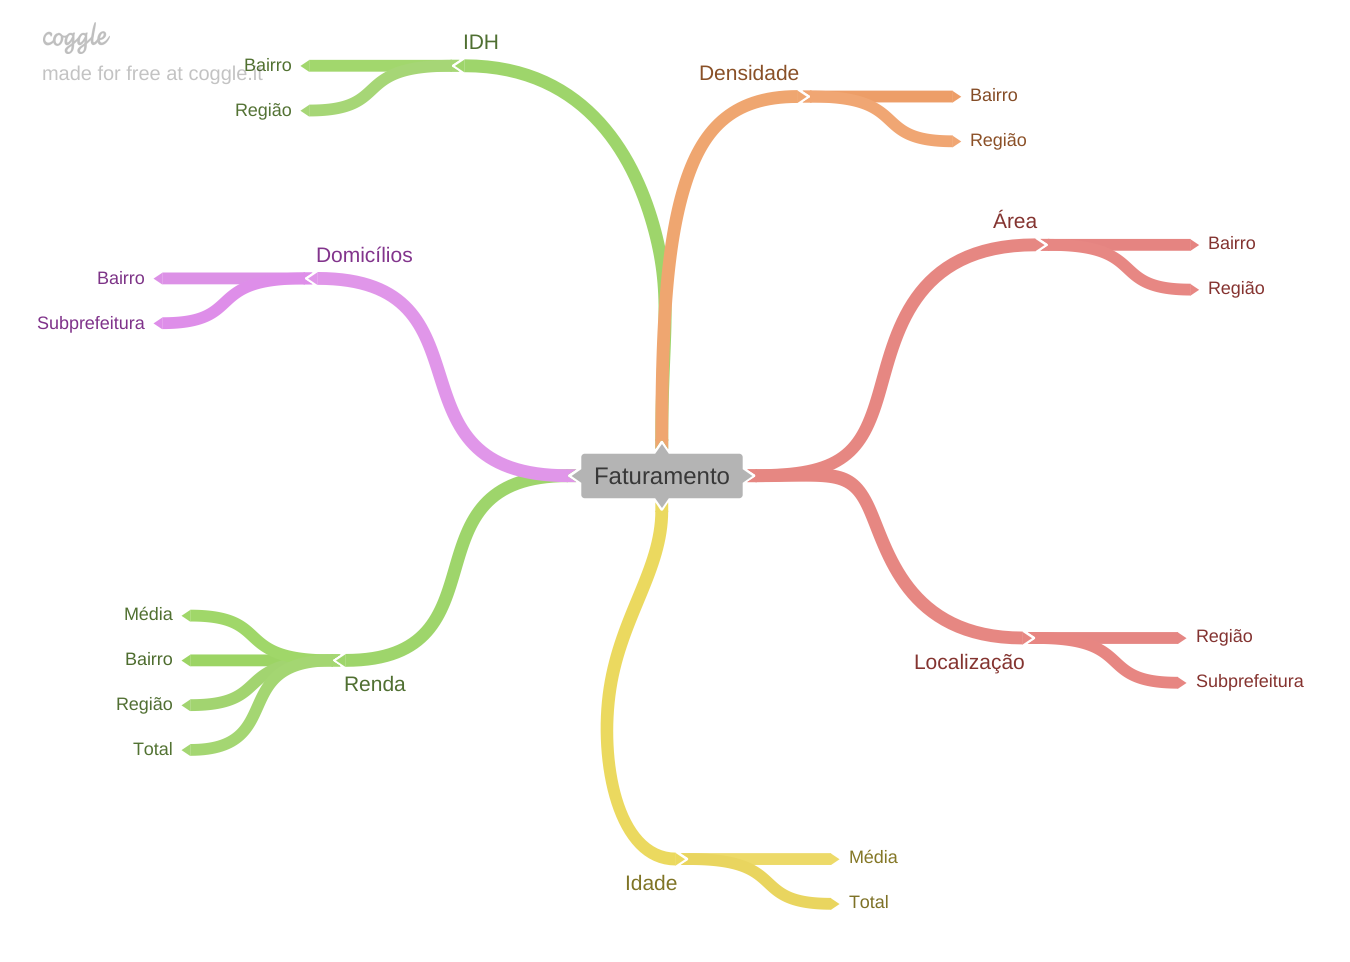

In [22]:
Image('/home/tcbm/projs/case_geofusion/img/Faturamento.png')

## 2.2. Hipoteses

**H1.** IDH Bairro x Faturamento

**H2.** IDH por Subprefeitura x Faturamento

**H3.** Densidade Bairro x Faturamento

**H4.** Densidade por Subprefeitura x Faturamento

**H5.** Renda total Bairro x Faturamento

**H6.** Renda Media Bairro x Faturamento

**H7.** Renda total por Subprefeitura x Faturamento

**H8.** Renda Media por Subprefeitura x Faturamento

**H9.** Bairro x Faturamento

**H10.** Regiao Adm x Faturamento

**H11.** Subprefeitura x Faturamento

**H12.** Idade Total Bairro x Faturamento

**H13.** Idade Total Subprefeitura x Faturamento

**H14.** Domicilio Bairro x Faturamento

**H15.** Domicilio Subprefeitura x Faturamento

**H16.** Populacao Absoluta Bairro x Faturamento

**H17.** Populacao Absoluta Subprefeitura x Faturamento

## 2.3. Feature Engineering

### 2.3.1. IDH medio por subprefeitura

In [23]:
aux_1 = df2[['idh', 'subprefeitura']].groupby('subprefeitura').mean().reset_index()
aux_1.columns = ['subprefeitura', 'idh_subprefeitura']
df2 = df2.merge(aux_1, how='inner', on='subprefeitura')

### 2.3.2. Populacao Subprefeitura

In [24]:
aux_2 = df2[['população', 'subprefeitura']].groupby('subprefeitura').sum().reset_index()
aux_2.columns = ['subprefeitura', 'população_subprefeitura']
df2 = df2.merge(aux_2, how='inner', on='subprefeitura')

### 2.3.3. Densidade Subprefeitura -> densidade = pop / area

In [25]:
aux_3 = df2[['area', 'subprefeitura']].groupby('subprefeitura').sum().reset_index()
aux_3.columns = ['subprefeitura', 'area_subprefeitura']
df2 = df2.merge(aux_3, how='inner', on='subprefeitura')

df2['densidade_subprefeitura'] = df2['população_subprefeitura'] / df2['area_subprefeitura']

df2 = df2.drop('area_subprefeitura', axis=1)

### 2.3.4. Densidade Bairro -> densidade = pop / area 

In [26]:
df2['densidade_bairro'] = df2['população'] / df2['area']

df2 = df2.drop('area', axis=1)

### 2.3.5. Renda total Bairro

In [27]:
df2['renda_abs_bairro'] = df2['renda_media'] * df2['população']

### 2.3.6 .Renda media Subprefeitura

In [28]:
aux_4 = df2.loc[:, ['nome', 'subprefeitura', 'renda_media', 'população', 'população_subprefeitura']]
aux_4['pond'] = aux_4['renda_media'] * aux_4['população'] / aux_4['população_subprefeitura']
df_merge_aux = aux_4[['pond', 'subprefeitura']].groupby('subprefeitura').sum().reset_index()
df_merge_aux.columns = ['subprefeitura', 'renda_media_subprefeitura']
df2 = df2.merge(df_merge_aux, how='inner', on='subprefeitura')

### 2.3.7. Domicílios percentuais por bairro

In [29]:
# total domicilios
df2['total_domicilios'] = (df2['domicilios_a1'] + df2['domicilios_a2'] +
                               df2['domicilios_b1'] + df2['domicilios_b2'] +
                               df2['domicilios_c1'] + df2['domicilios_c2'] +
                               df2['domicilios_d'] + df2['domicilios_e'])

# percent
df2['percent_domicilios_a1'] = df2['domicilios_a1'] / df2['total_domicilios']
df2['percent_domicilios_a2'] = df2['domicilios_a2'] / df2['total_domicilios']
df2['percent_domicilios_b1'] = df2['domicilios_b1'] / df2['total_domicilios']
df2['percent_domicilios_b2'] = df2['domicilios_b2'] / df2['total_domicilios']
df2['percent_domicilios_c1'] = df2['domicilios_c1'] / df2['total_domicilios']
df2['percent_domicilios_c2'] = df2['domicilios_c2'] / df2['total_domicilios']
df2['percent_domicilios_d'] = df2['domicilios_d'] / df2['total_domicilios']
df2['percent_domicilios_e'] = df2['domicilios_e'] / df2['total_domicilios']

df2 = df2.drop(['domicilios_a1', 'domicilios_a2', 'domicilios_b1', 
                'domicilios_b2', 'domicilios_c1', 'domicilios_c2',
                'domicilios_d', 'domicilios_e'], axis=1)

###  2.3.8. percent_idade_bairro

In [30]:
df2['percent_pop_ate9'] = df2['pop_ate9'] / df2['população']
df2['percent_pop_de10a14'] = df2['pop_de10a14'] / df2['população']
df2['percent_pop_de15a19'] = df2['pop_de15a19'] / df2['população']
df2['percent_pop_de20a24'] = df2['pop_de20a24'] / df2['população']
df2['percent_pop_de25a34'] = df2['pop_de25a34'] / df2['população']
df2['percent_pop_de35a49'] = df2['pop_de35a49'] / df2['população']
df2['percent_pop_de50a59'] = df2['pop_de50a59'] / df2['população']
df2['percent_pop_mais_de60'] = df2['pop_mais_de60'] / df2['população']

df2 = df2.drop(['pop_ate9', 'pop_de10a14', 'pop_de15a19', 'pop_de20a24',
                'pop_de25a34', 'pop_de35a49', 'pop_de50a59', 'pop_mais_de60'], axis=1)

# 3.0. Exploratory Data Analysis

In [197]:
df3 = df2.copy()
#df3.to_csv('df_to_analysis.csv', encoding='utf-8', index=False)

## 3.1. Analise Univariada

### 3.1.1. Variavel Resposta

<AxesSubplot:xlabel='faturamento', ylabel='Count'>

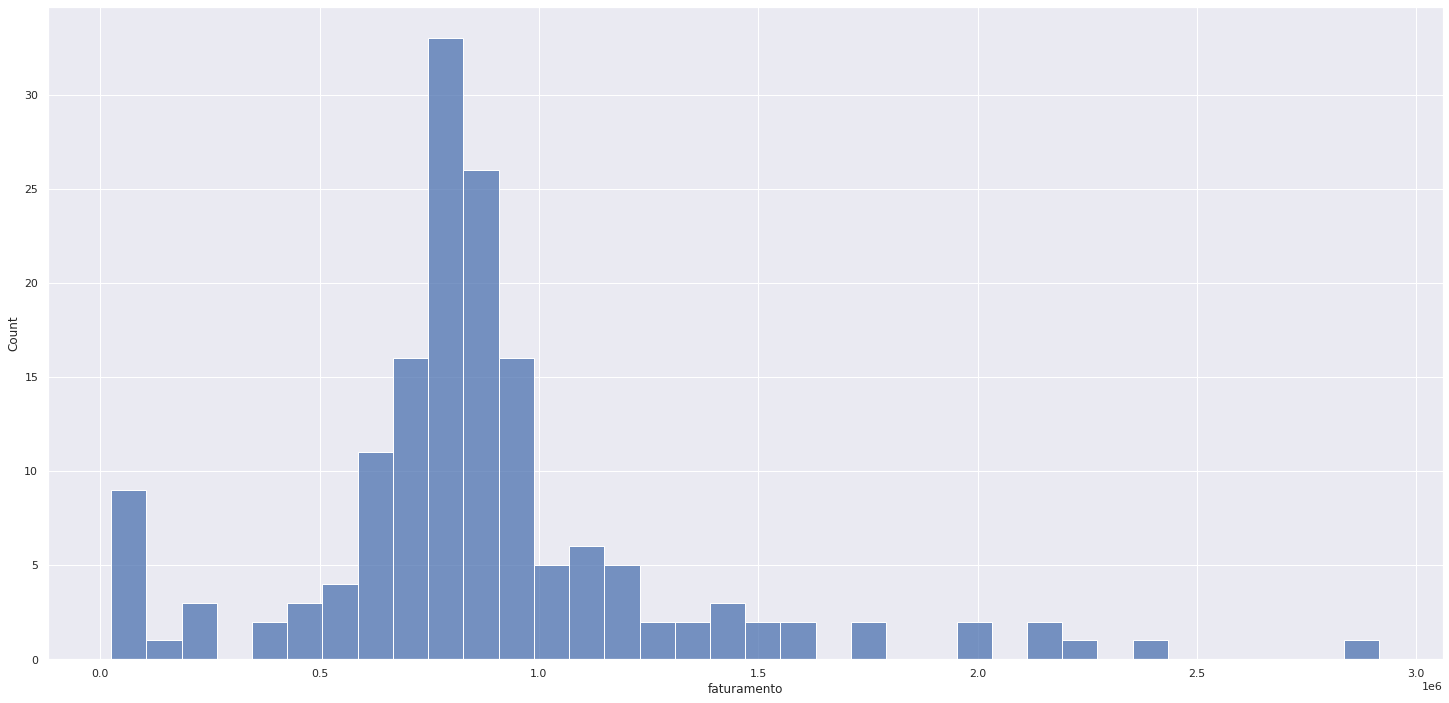

In [32]:
sns.histplot(df2['faturamento'])

### 3.1.2. Variaveis Numéricas

In [33]:
num_attributes = df3.select_dtypes(exclude='object')


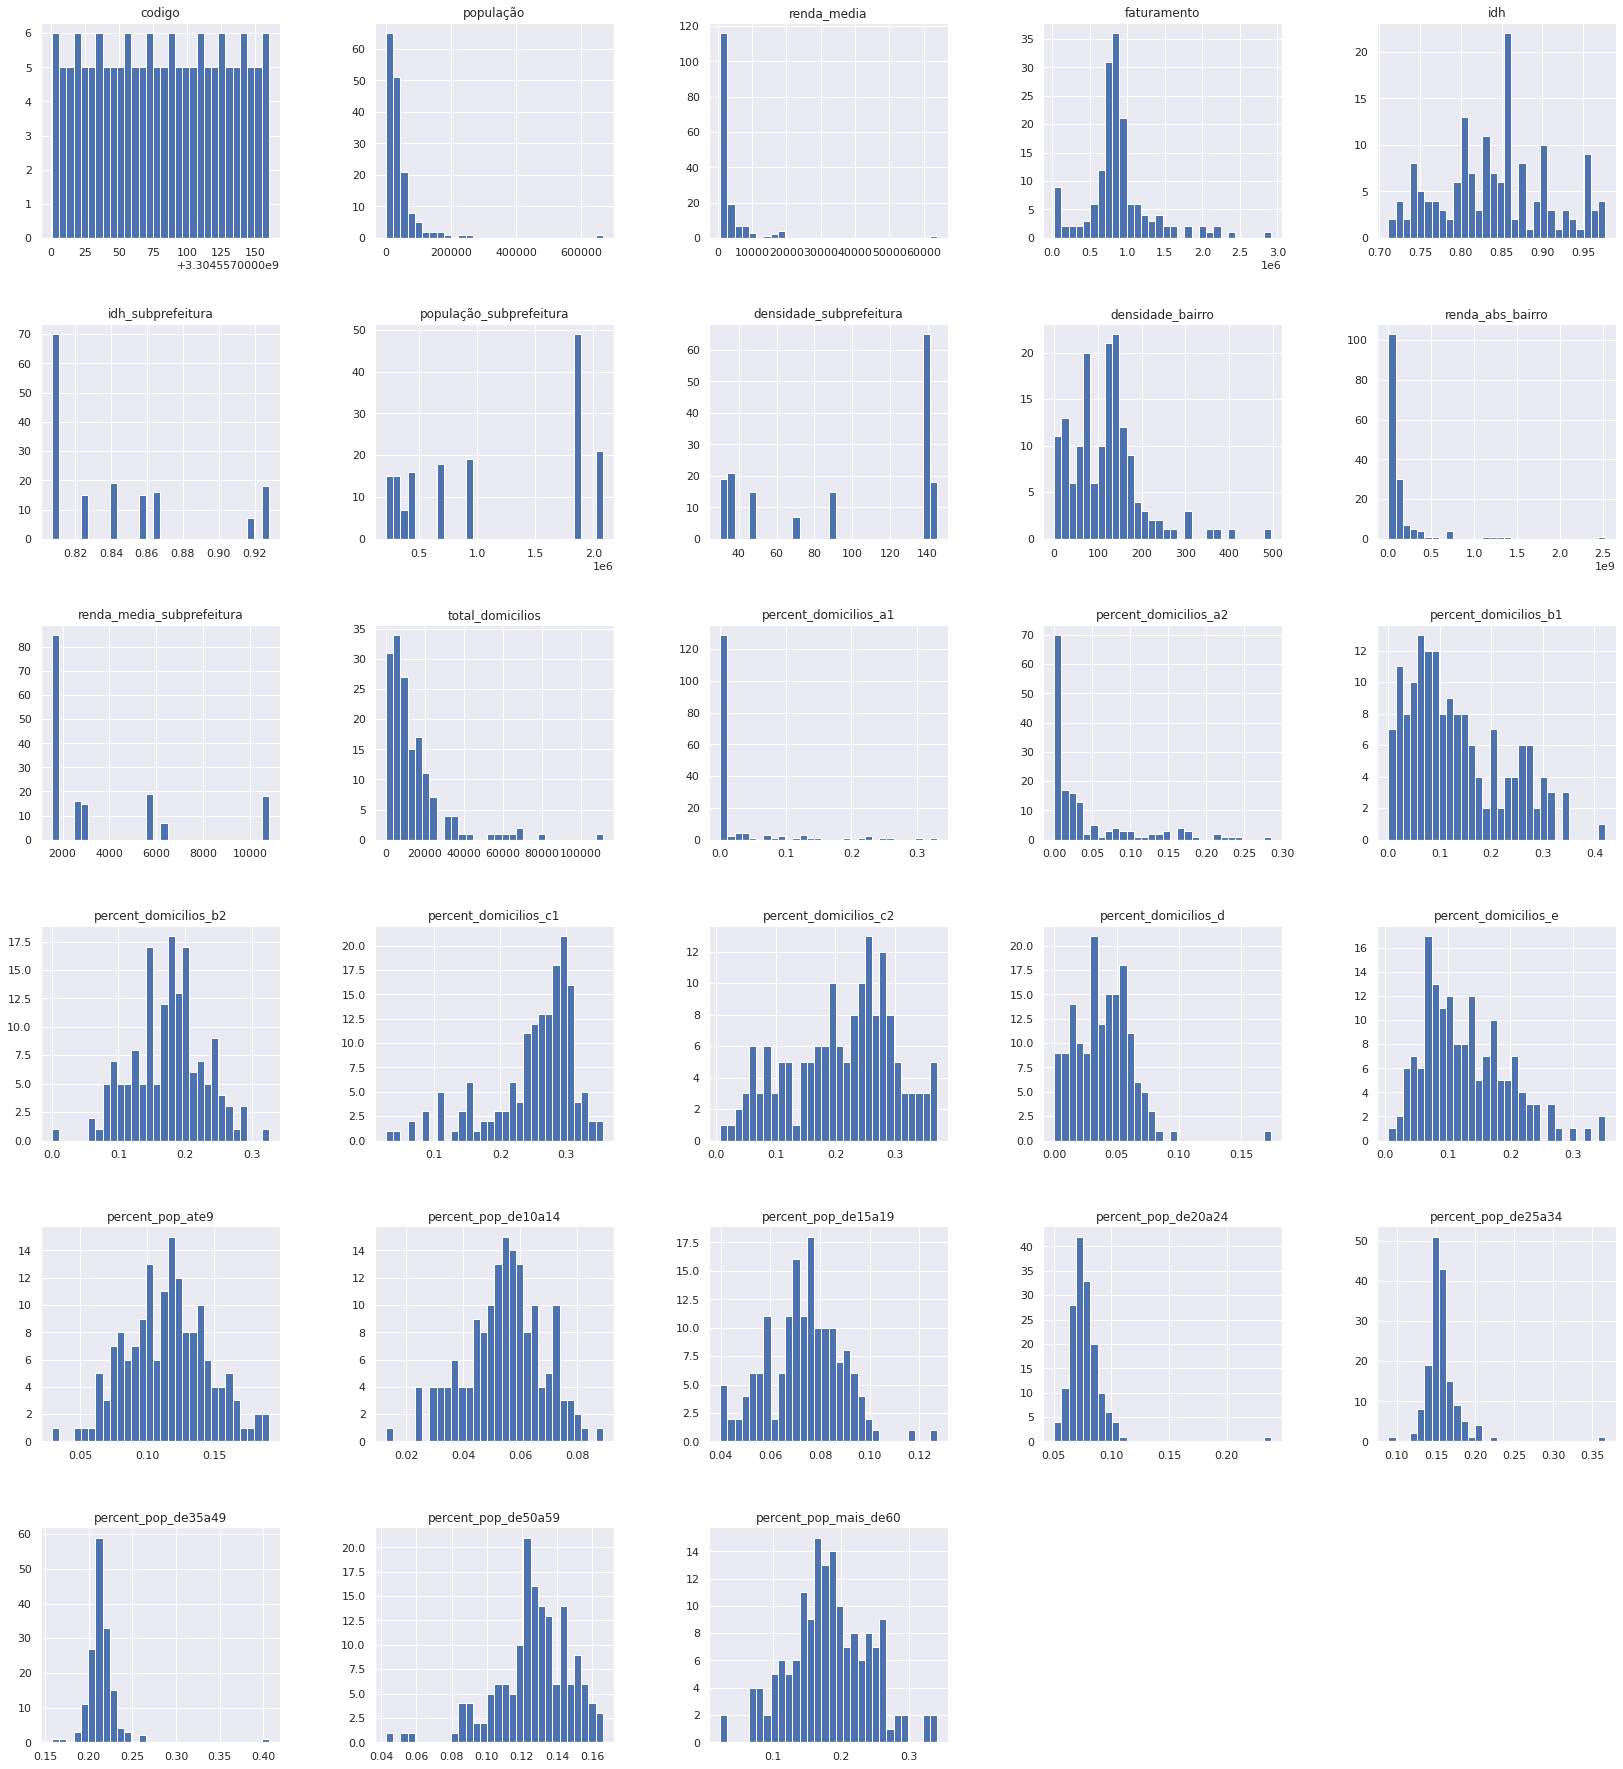

In [34]:
num_attributes.hist(bins=30);
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.40)

### 3.1.3. Variaveis Categoricas

In [35]:
cat_attributes = df3.select_dtypes(include='object')

<AxesSubplot:xlabel='subprefeitura', ylabel='faturamento'>

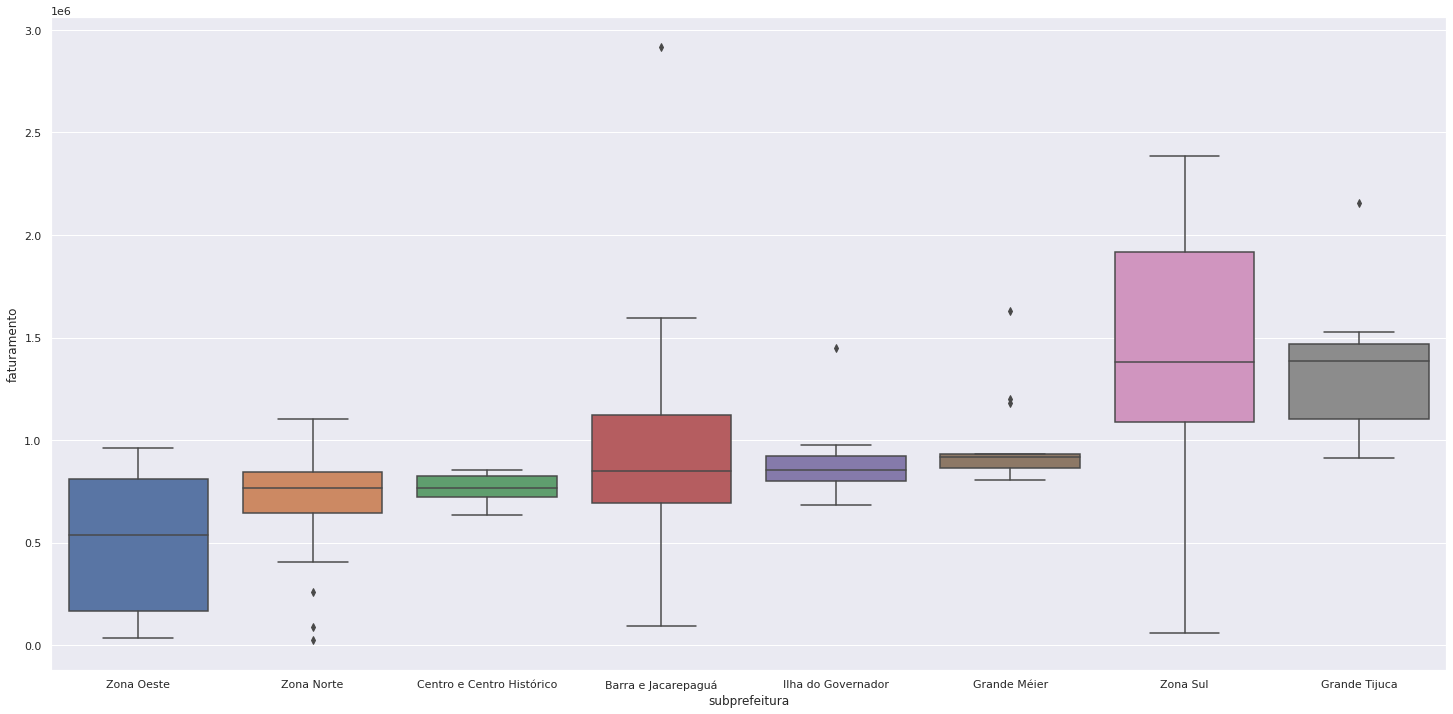

In [36]:
# Criando um df auxiliar para agrupar os valores pela mediana
aux = df1[['subprefeitura', 'faturamento']].groupby('subprefeitura').median().reset_index().sort_values(by = 'faturamento',
                                                                                                        ascending=True)
# plot boxplot
sns.boxplot(x='subprefeitura', y='faturamento', data=df1, order = aux['subprefeitura'].to_list())

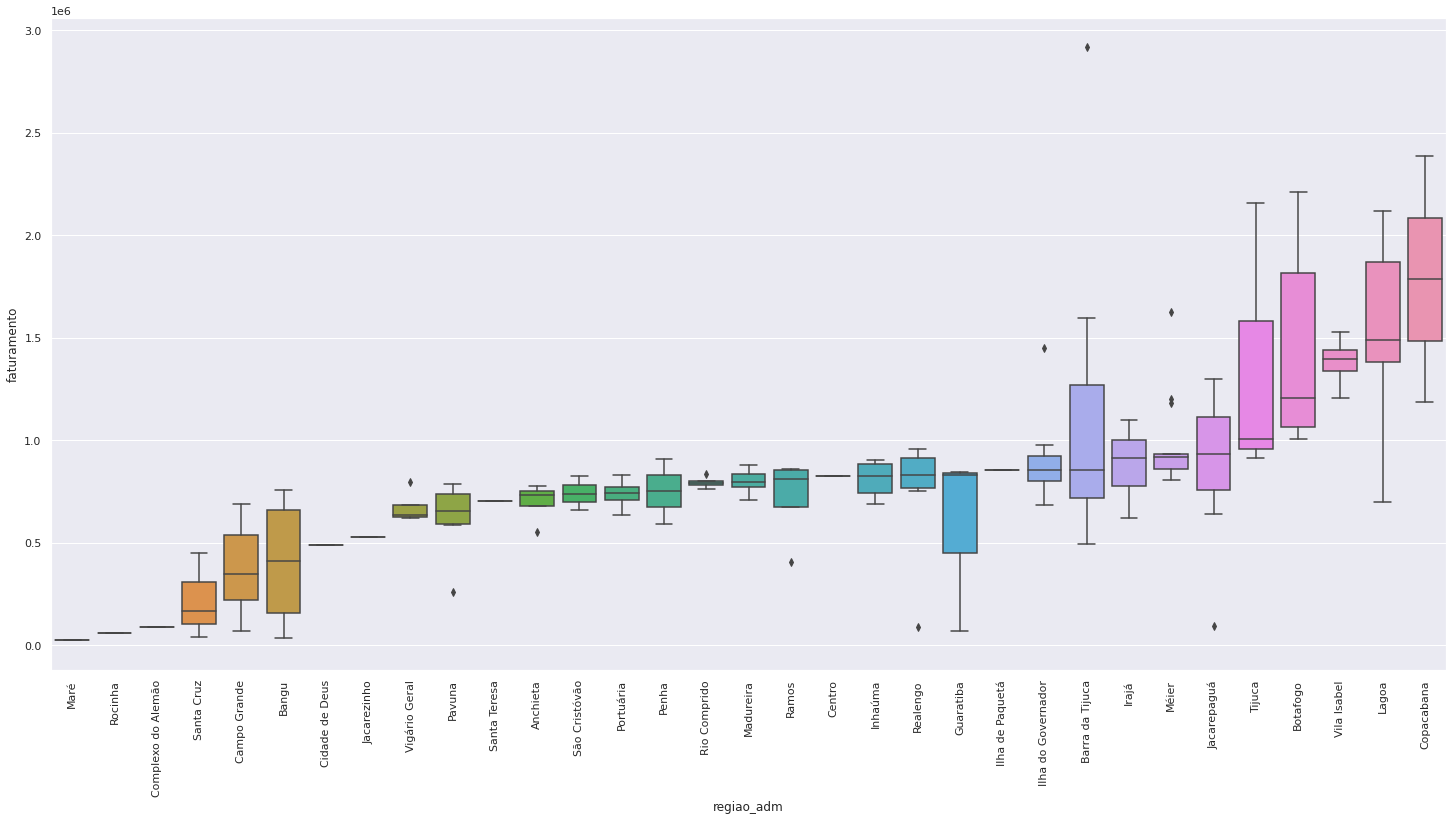

In [37]:
# Criando um df auxiliar para agrupar os valores pela mediana
aux = df1[['regiao_adm', 'faturamento']].groupby('regiao_adm').median().reset_index().sort_values(by = 'faturamento',
                                                                                                        ascending=True)
# plot boxplot
sns.boxplot(x='regiao_adm', y='faturamento', data=df1, order = aux['regiao_adm'].to_list())

plt.xticks(rotation=90);

## 3.2. Analise Bivariada

### H1. IDH Bairro x Faturamento
- o IDH do bairro e o Faturamento possuem boa correlação;
- IDH's mais elevados dos bairros são acompanhados, em boa parte dos casos, de maiores faturamentos.

In [38]:
# criando auxiliar para plotar categorias de idh por faturamento
aux = df3.loc[:, ['idh', 'faturamento']]
aux['idh'] = pd.cut(df3['idh'], bins=5)
aux_2 = aux.groupby('idh').mean().reset_index()

<AxesSubplot:>

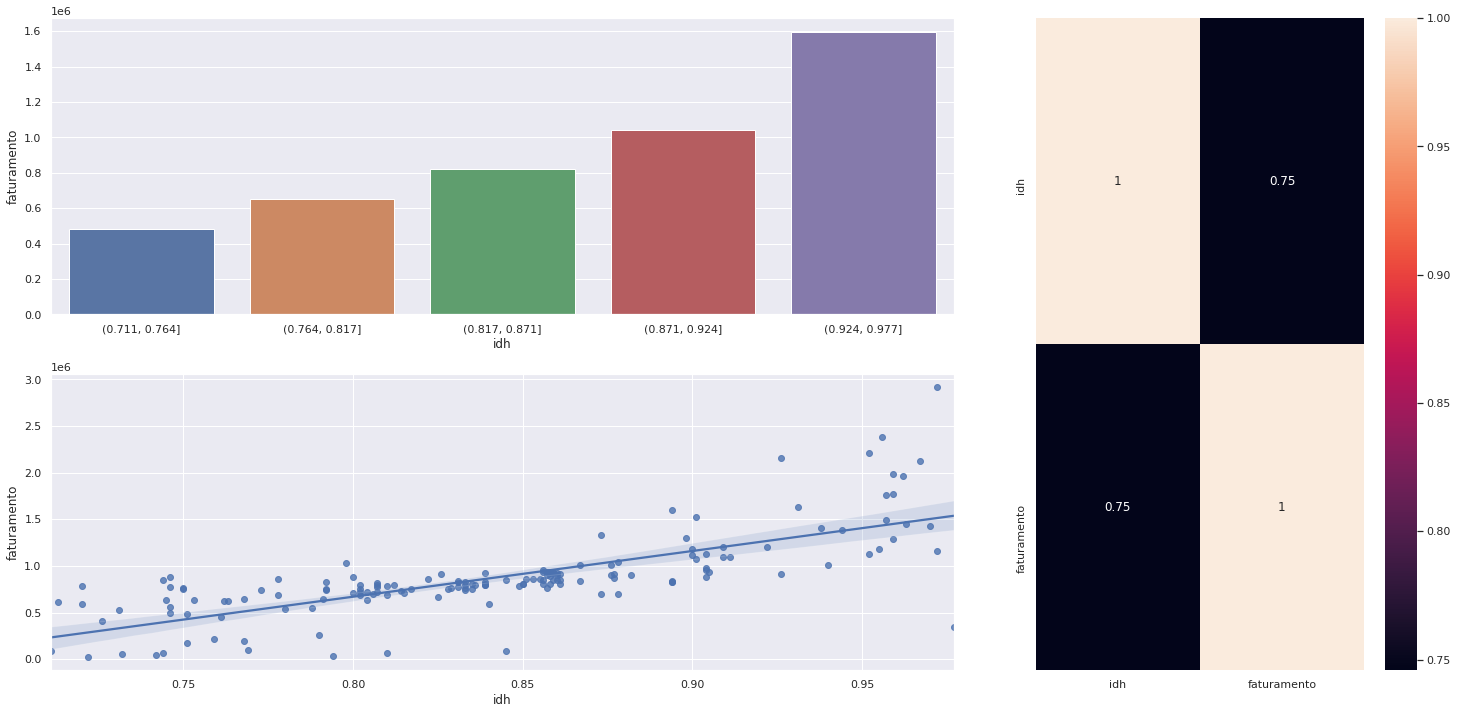

In [39]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot barplot categorias
sns.barplot(x='idh', y='faturamento', data=aux_2)

plt.subplot(grid[1, :2])
# plot regressão entre idh e faturamento
sns.regplot(x='idh', y='faturamento', data=df3)

plt.subplot(grid[:, 2])
# plot correlacao entre as variáveis idh e faturamentop
sns.heatmap(df3[['idh', 'faturamento']].corr(method='pearson'), annot=True)

### H2. IDH por Subprefeitura x Faturamento
- o IDH da Subprefeitura e o Faturamento possuem uma correlação interessante;
- IDH's mais elvados das Subprefeituras são acompanhados, em boa parte dos casos, de maiores faturamentos.

In [40]:
# criando auxiliar para plotar categorias de idh por faturamento
aux = df3.loc[:, ['idh_subprefeitura', 'faturamento']]
aux['idh_subprefeitura'] = pd.cut(df3['idh_subprefeitura'], bins=3)
aux_2 = aux.groupby('idh_subprefeitura').mean().reset_index()

<AxesSubplot:>

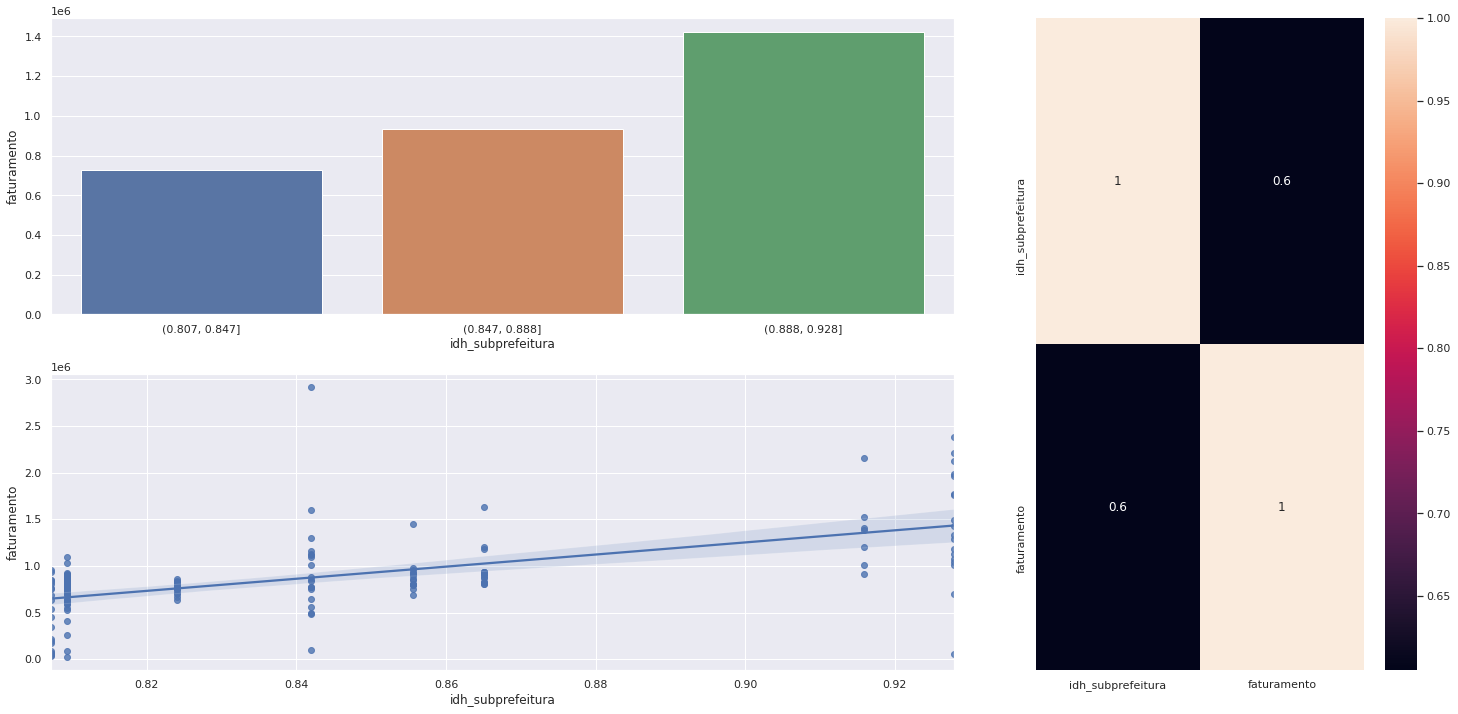

In [41]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot barplot categorias
sns.barplot(x='idh_subprefeitura', y='faturamento', data=aux_2)

plt.subplot(grid[1, :2])
# plot regressão entre idh e faturamento
sns.regplot(x='idh_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[:, 2])
# plot correlacao entre as variáveis idh e faturamento
sns.heatmap(df3[['idh_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

### **H3.** Densidade Bairro x Faturamento
 - A Densidade do Bairro e o Faturamento possuem uma baixa correlação.

In [42]:
# criando auxiliar para plotar categorias de idh por faturamento
aux = df3.loc[:, ['densidade_bairro', 'faturamento']]
aux['densidade_bairro'] = pd.cut(df3['densidade_bairro'], bins=3)
aux_2 = aux.groupby('densidade_bairro').mean().reset_index()

<AxesSubplot:>

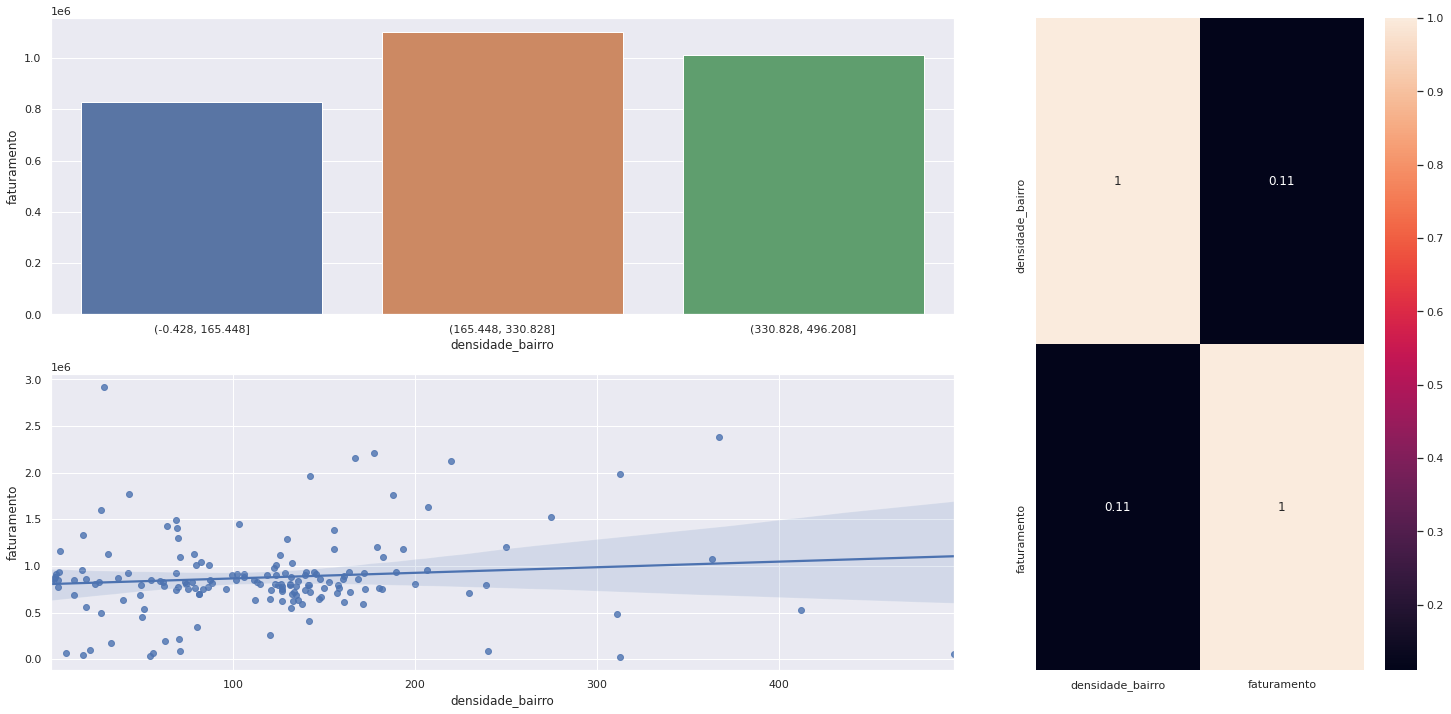

In [43]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot barplot categorias
sns.barplot(x='densidade_bairro', y='faturamento', data=aux_2)

plt.subplot(grid[1, :2])
# plot regressão entre idh e faturamento
sns.regplot(x='densidade_bairro', y='faturamento', data=df3)

plt.subplot(grid[:, 2])
# plot correlacao entre as variáveis idh e faturamento
sns.heatmap(df3[['densidade_bairro', 'faturamento']].corr(method='pearson'), annot=True)

### H4. Densidade por Subprefeitura x Faturamento
 - A Densidade da Subprefeitura e o Faturamento possuem uma baixa correlação.

In [44]:
# criando auxiliar para plotar categorias de idh por faturamento
aux = df3.loc[:, ['densidade_subprefeitura', 'faturamento']]
aux['densidade_subprefeitura'] = pd.cut(df3['densidade_subprefeitura'], bins=3)
aux_2 = aux.groupby('densidade_subprefeitura').mean().reset_index()

<AxesSubplot:>

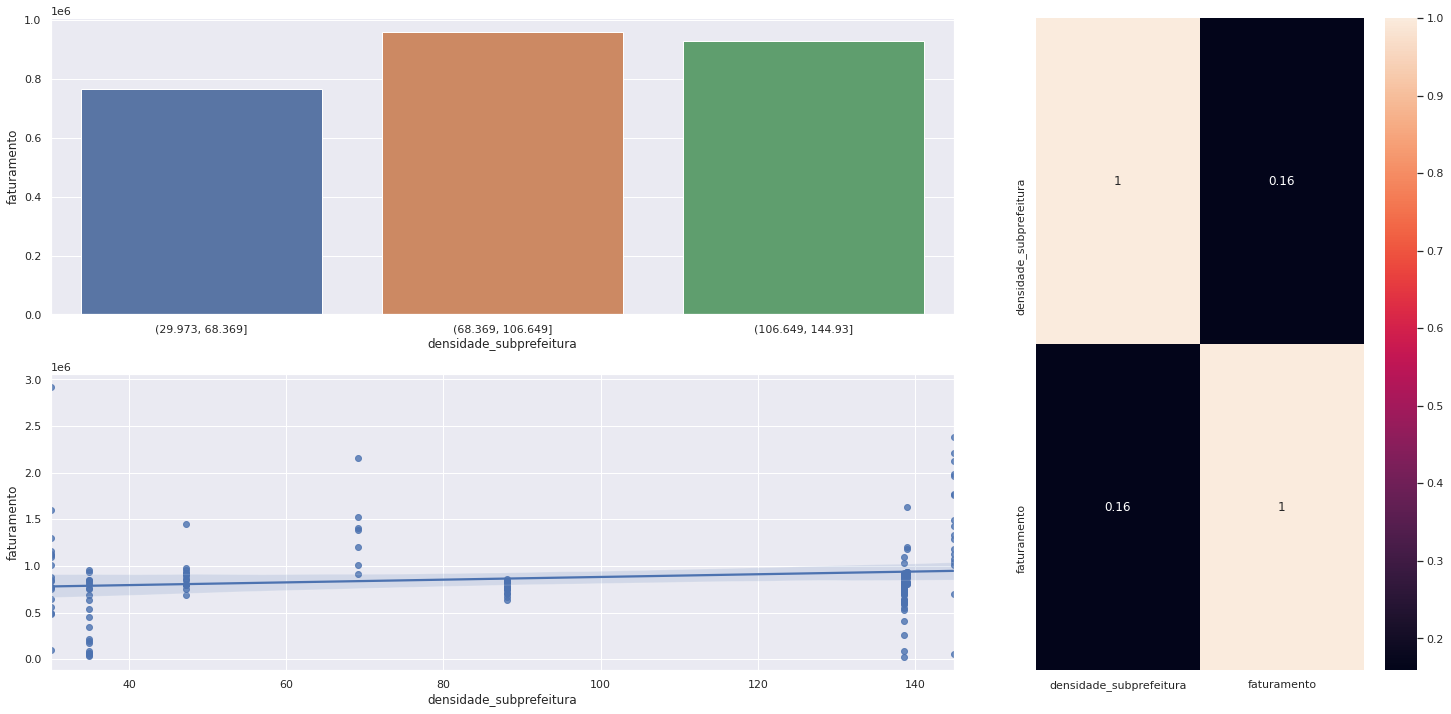

In [45]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot barplot categorias
sns.barplot(x='densidade_subprefeitura', y='faturamento', data=aux_2)

plt.subplot(grid[1, :2])
# plot regressão entre idh e faturamento
sns.regplot(x='densidade_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[:, 2])
# plot correlacao entre as variáveis idh e faturamento
sns.heatmap(df3[['densidade_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

### H5. Renda total Bairro x Faturamento
- Existe alguma correlação entre a Renda total do Bairro e o faturamento;
- Valores altos de renda(que são outliers) possuem valores de faturamento superior.

In [46]:
# Selecionando valores inferiores aos outliers
aux_1 = df3.loc[df3['renda_abs_bairro'] < 300000000, :]

<AxesSubplot:>

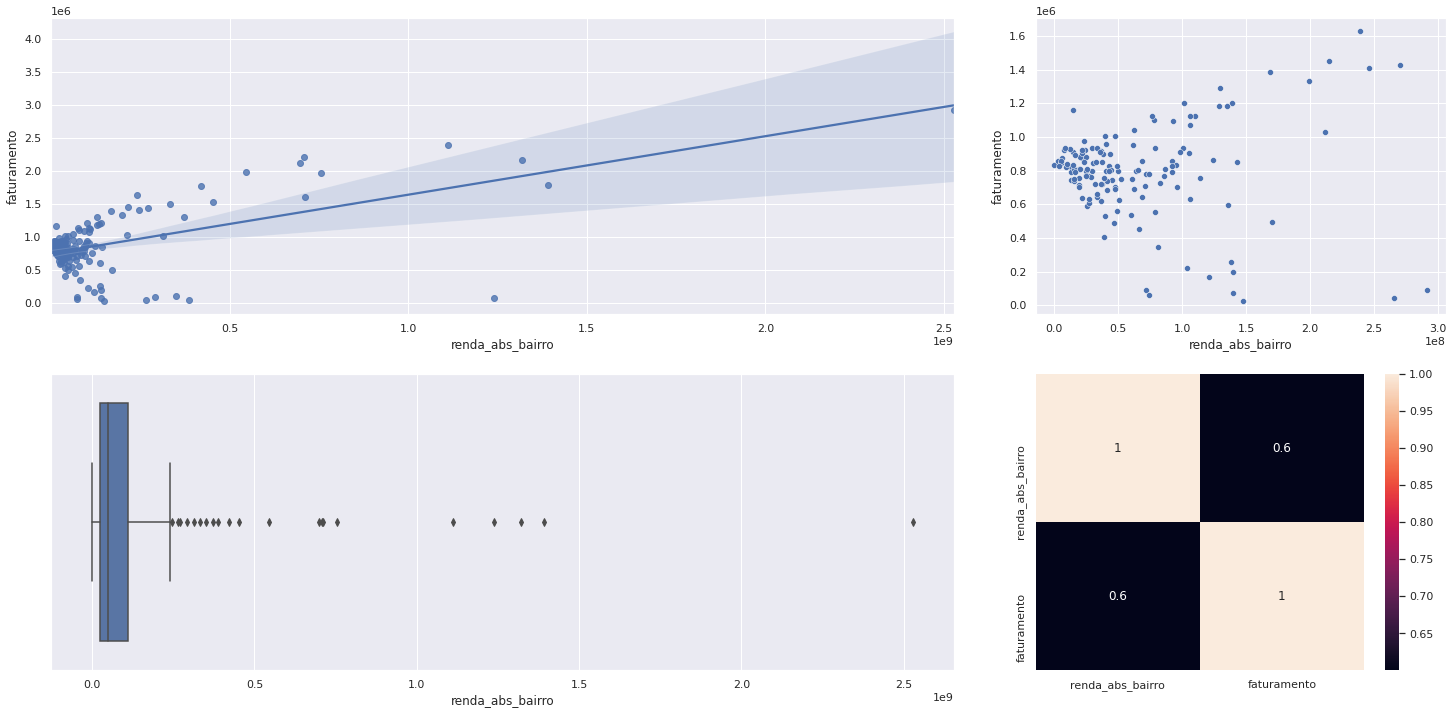

In [47]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot regressão incluindo outliers
sns.regplot(x='renda_abs_bairro', y='faturamento', data=df3)

plt.subplot(grid[1, :2])
# plot boxplot renda absoluta
sns.boxplot(x = df3['renda_abs_bairro'])

plt.subplot(grid[0, 2])
# plot scatterplot renda absoluta sem outliers
sns.scatterplot(x='renda_abs_bairro', y='faturamento', data=aux_1)

plt.subplot(grid[1, 2])
# plot heatmap de correlação
sns.heatmap(df3[['renda_abs_bairro', 'faturamento']].corr(method='pearson'), annot=True)

### H6. Renda Média Bairro x Faturamento
- Existe alguma correlação entre a Renda média do Bairro e o faturamento;
- Valores altos de renda possuem valores de faturamento superior.

In [48]:
# Selecionando valores inferiores aos outliers
aux_1 = df3.loc[df3['renda_abs_bairro'] < 300000000, :]

<AxesSubplot:>

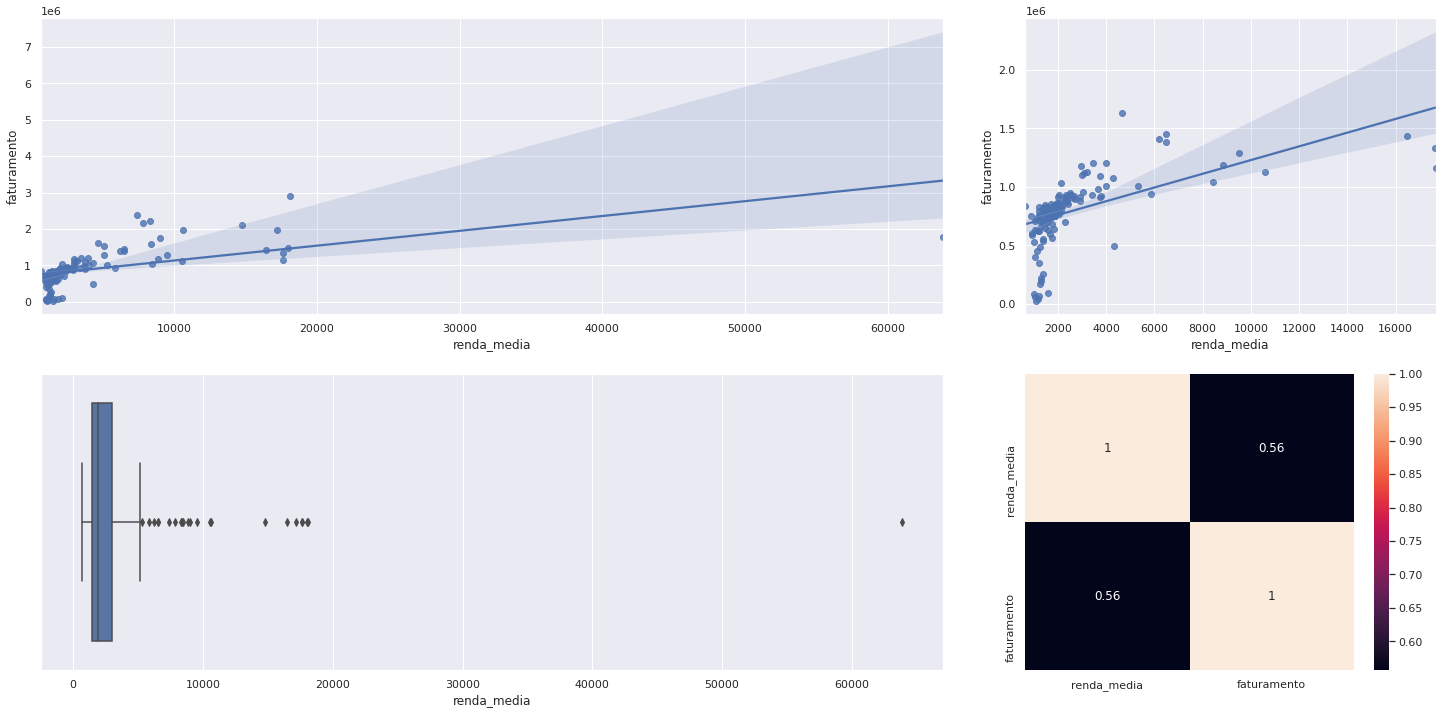

In [49]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot regressão incluindo outliers
sns.regplot(x='renda_media', y='faturamento', data=df3)

plt.subplot(grid[1, :2])
# plot boxplot renda absoluta
sns.boxplot(x = df3['renda_media'])

plt.subplot(grid[0, 2])
# plot scatterplot renda absoluta sem outliers
sns.regplot(x='renda_media', y='faturamento', data=aux_1)

plt.subplot(grid[1, 2])
# plot heatmap de correlação
sns.heatmap(df3[['renda_media', 'faturamento']].corr(method='pearson'), annot=True)

### H7. Renda total por Subprefeitura x Faturamento
- A correlação entre a Renda bruta por subprefeitura e o faturamento é mínima.

In [50]:
df3['renda_abs_subprefeitura'] = df3['renda_media_subprefeitura'] * df3['população_subprefeitura']

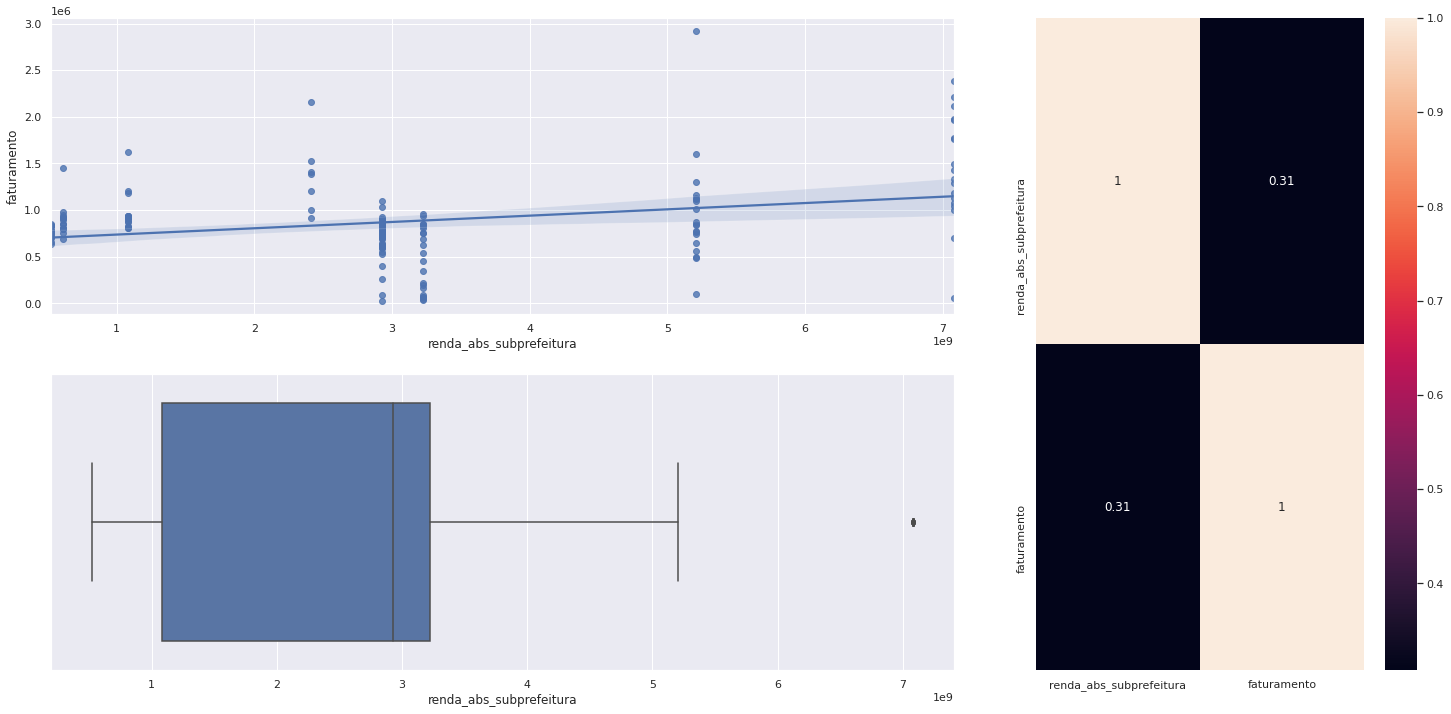

In [51]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot regressão incluindo
sns.regplot(x='renda_abs_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[1, :2])
# plot boxplot renda absoluta
sns.boxplot(x = df3['renda_abs_subprefeitura'])

plt.subplot(grid[:, 2])
# plot heatmap de correlação
sns.heatmap(df3[['renda_abs_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

df3 = df3.drop('renda_abs_subprefeitura', axis=1)

### H8. Renda Média por Subprefeitura x Faturamento
- Existe alguma correlação entre a Renda média da subprefeitura e o faturamento;
- Valores altos de renda possuem valores de faturamento superior.

<AxesSubplot:>

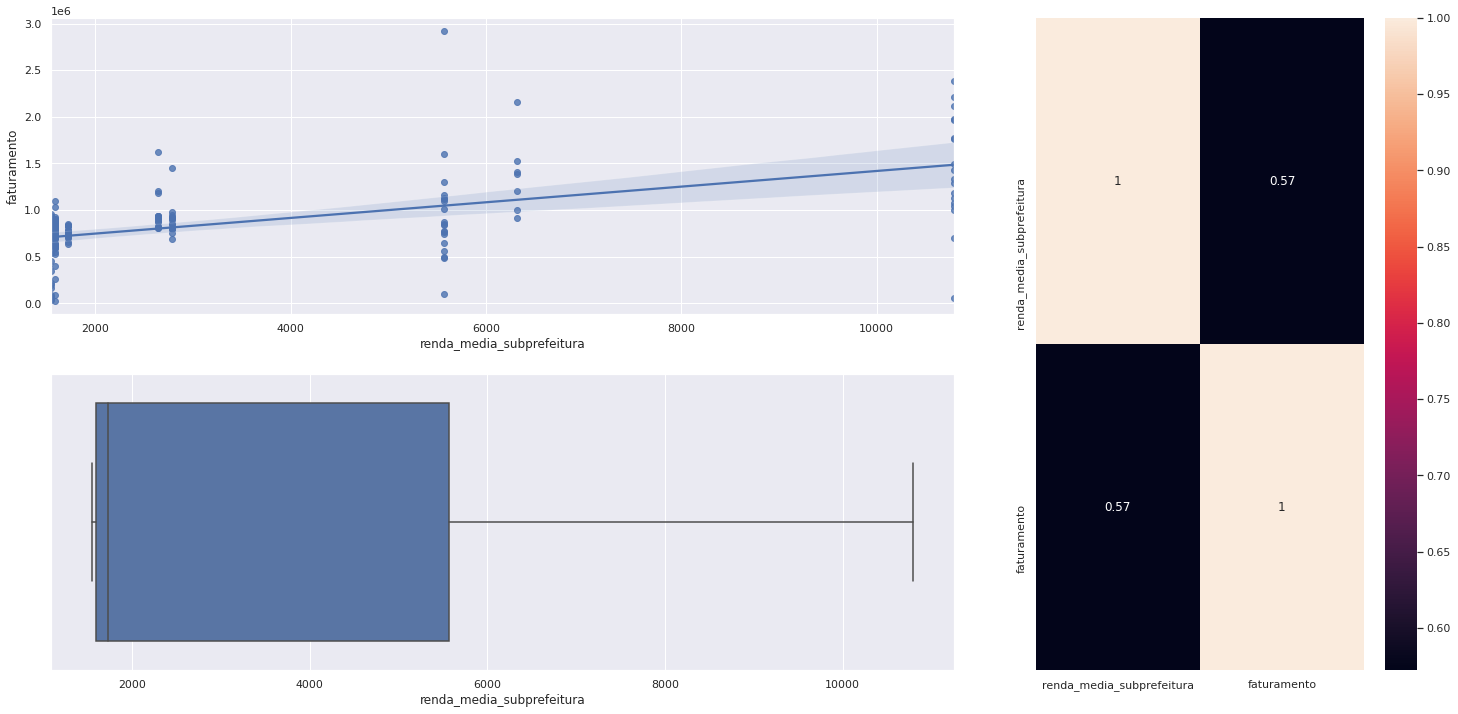

In [52]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot regressão incluindo
sns.regplot(x='renda_media_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[1, :2])
# plot boxplot renda absoluta
sns.boxplot(x = df3['renda_media_subprefeitura'])

plt.subplot(grid[:, 2])
# plot heatmap de correlação
sns.heatmap(df3[['renda_media_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

### H9. Bairro x Faturamento - Top 10 Faturamentos - Bairros

In [53]:
aux = df3.sort_values(by='faturamento', ascending=True).iloc[-10:, :]

<AxesSubplot:xlabel='nome', ylabel='faturamento'>

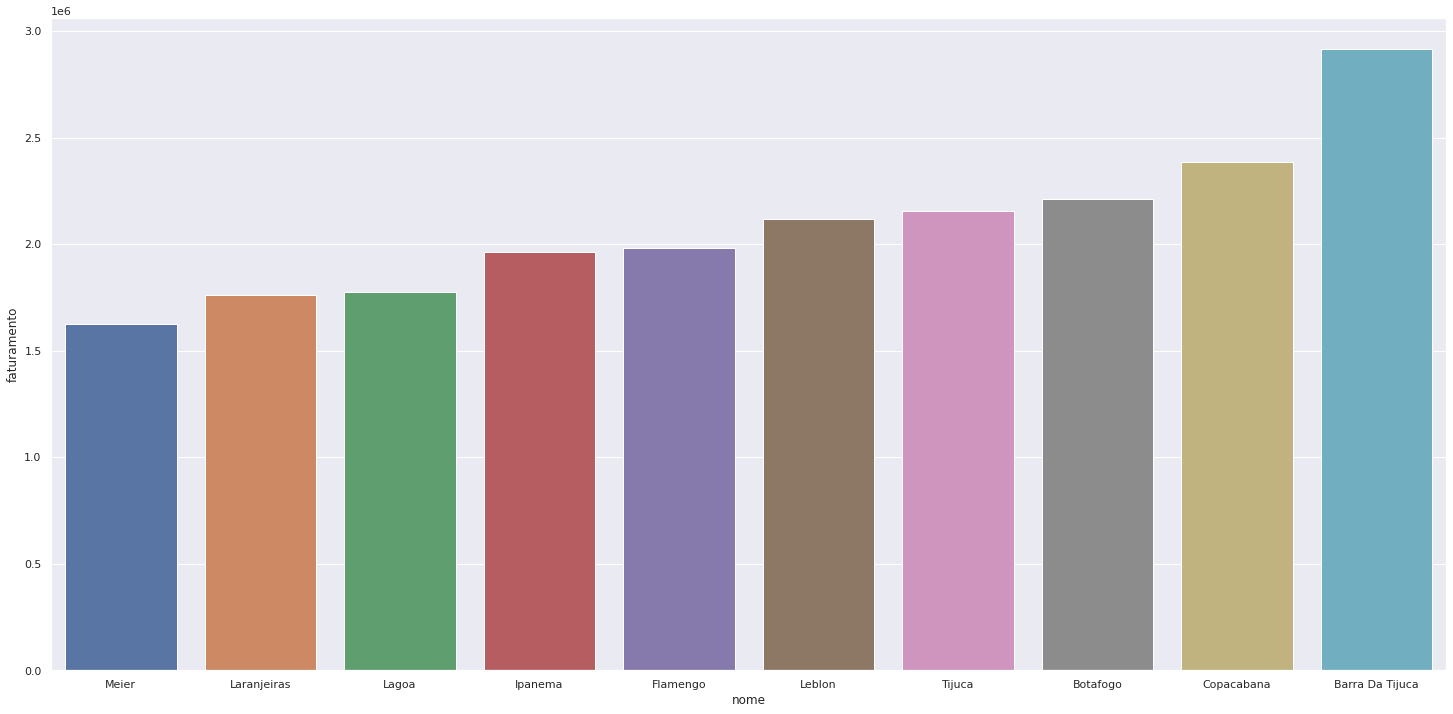

In [54]:
sns.barplot(x='nome', y='faturamento', data=aux)

### H10. Região Adm x Faturamento - Top 10 Faturamentos - Região Administrativa

In [55]:
# Regioes com maior faturamento - Absoluto
aux = df3[['regiao_adm', 'faturamento']].groupby('regiao_adm').sum().sort_values(by='faturamento').reset_index()
aux_2 = aux.loc[23:, :]

# Regioes com maior faturamento - Mediana
aux_3 = df3[['regiao_adm', 'faturamento']].groupby('regiao_adm').median().sort_values(by='faturamento').reset_index()
aux_4 = aux_3.loc[23:, :]

Text(0.5, 1.0, 'Top 10 Faturamento Mediano por Região Administrativa')

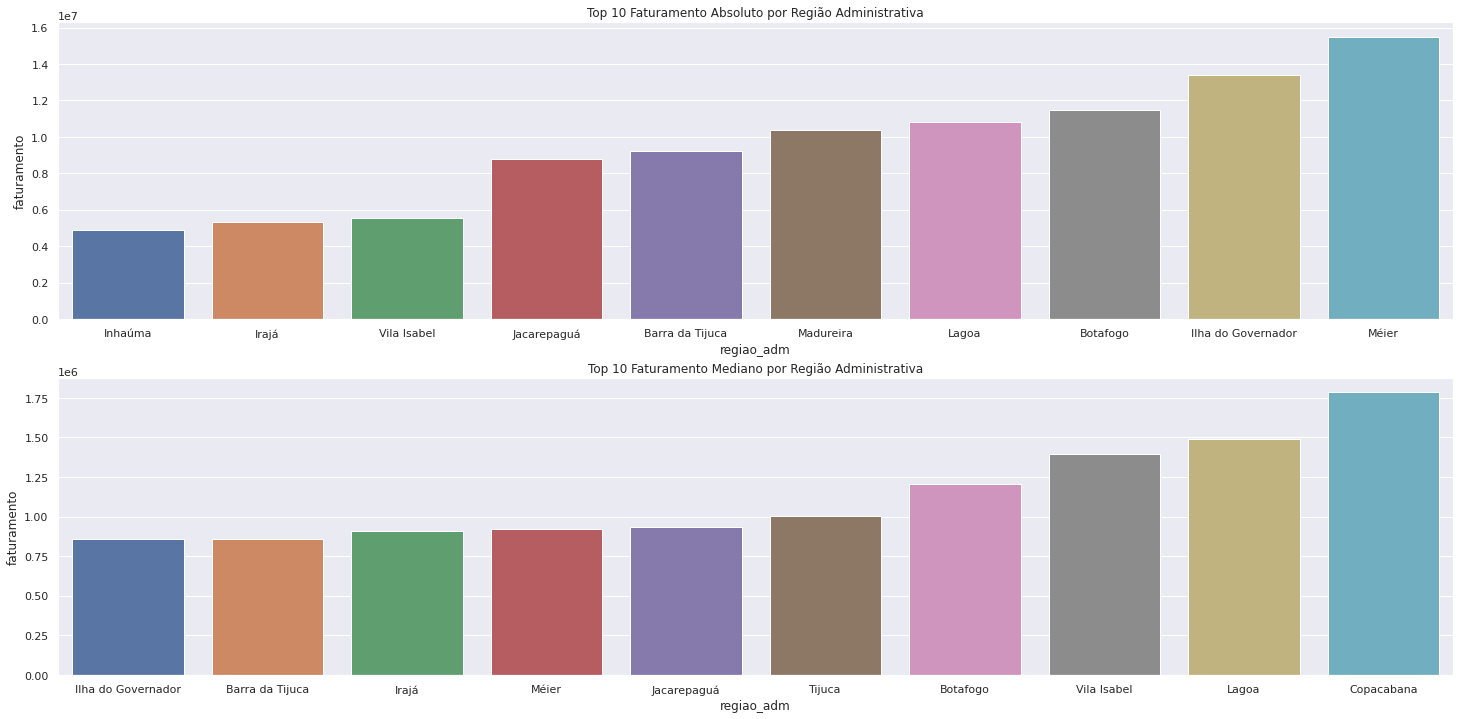

In [56]:
grid = plt.GridSpec(2, 1)

plt.subplot(grid[0, 0])
# plot rank de faturamento absoluto
sns.barplot(x='regiao_adm', y='faturamento', data=aux_2)
plt.title('Top 10 Faturamento Absoluto por Região Administrativa')

plt.subplot(grid[1, 0])
# plot rank de faturamento mediano
sns.barplot(x='regiao_adm', y='faturamento', data=aux_4)
plt.title('Top 10 Faturamento Mediano por Região Administrativa')

### H11. Subprefeitura x Faturamento Top 10 Faturamentos - Subprefeitura

In [57]:
# Regioes com maior faturamento - Absoluto
aux = df3[['subprefeitura', 'faturamento']].groupby('subprefeitura').sum().sort_values(by='faturamento').reset_index()

# Regioes com maior faturamento - Mediana
aux_2 = df3[['subprefeitura', 'faturamento']].groupby('subprefeitura').median().sort_values(by='faturamento').reset_index()

Text(0.5, 1.0, 'Top 10 Faturamento Mediano por Subprefeitura')

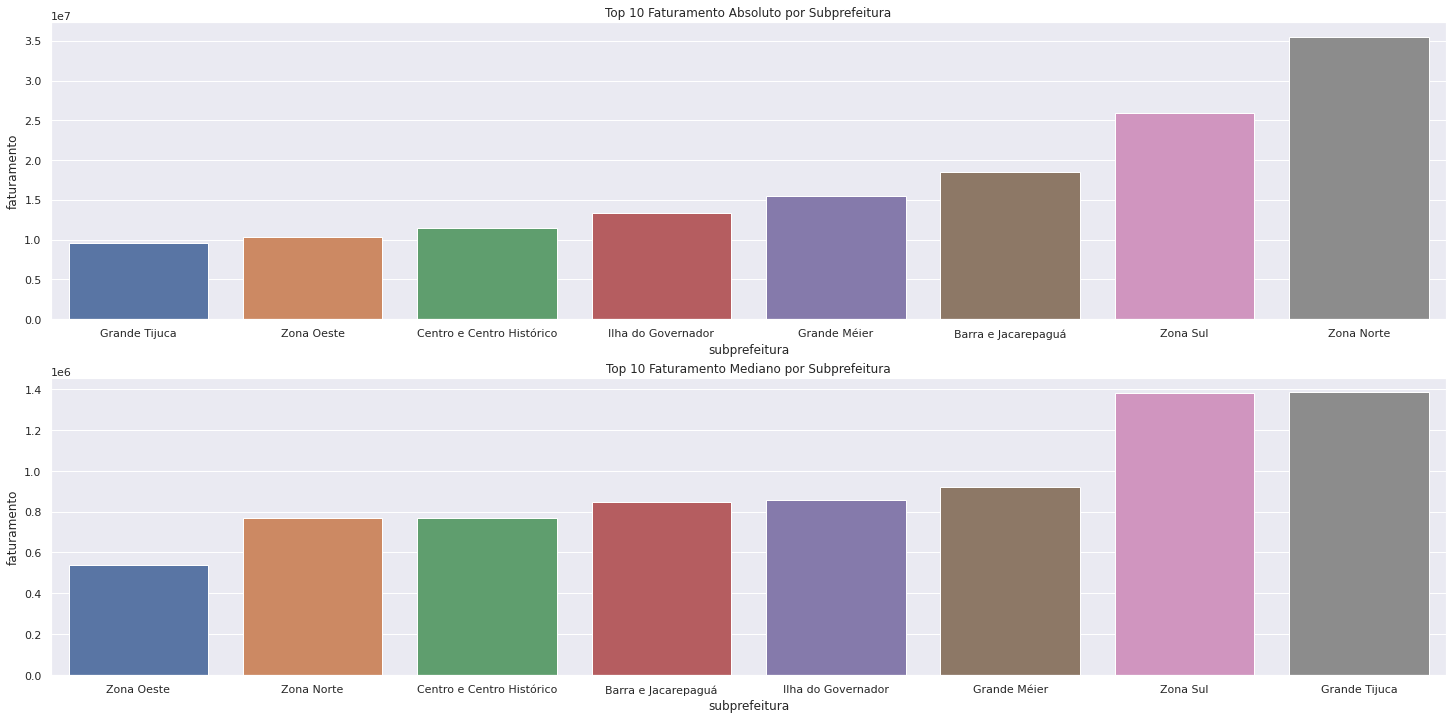

In [58]:
grid = plt.GridSpec(2, 1)

plt.subplot(grid[0, 0])
# plot rank de faturamento absoluto
sns.barplot(x='subprefeitura', y='faturamento', data=aux)
plt.title('Top 10 Faturamento Absoluto por Subprefeitura')

plt.subplot(grid[1, 0])
# plot rank de faturamento mediano
sns.barplot(x='subprefeitura', y='faturamento', data=aux_2)
plt.title('Top 10 Faturamento Mediano por Subprefeitura')

### H12. Idade Total Bairro x Faturamento
- Em bairros onde a porcentagem de pessoas mais velhas é superior, o faturamento é maior.
- Em bairros onde a porcentagem de pessoas mais novas é superior, o faturamento é menor.

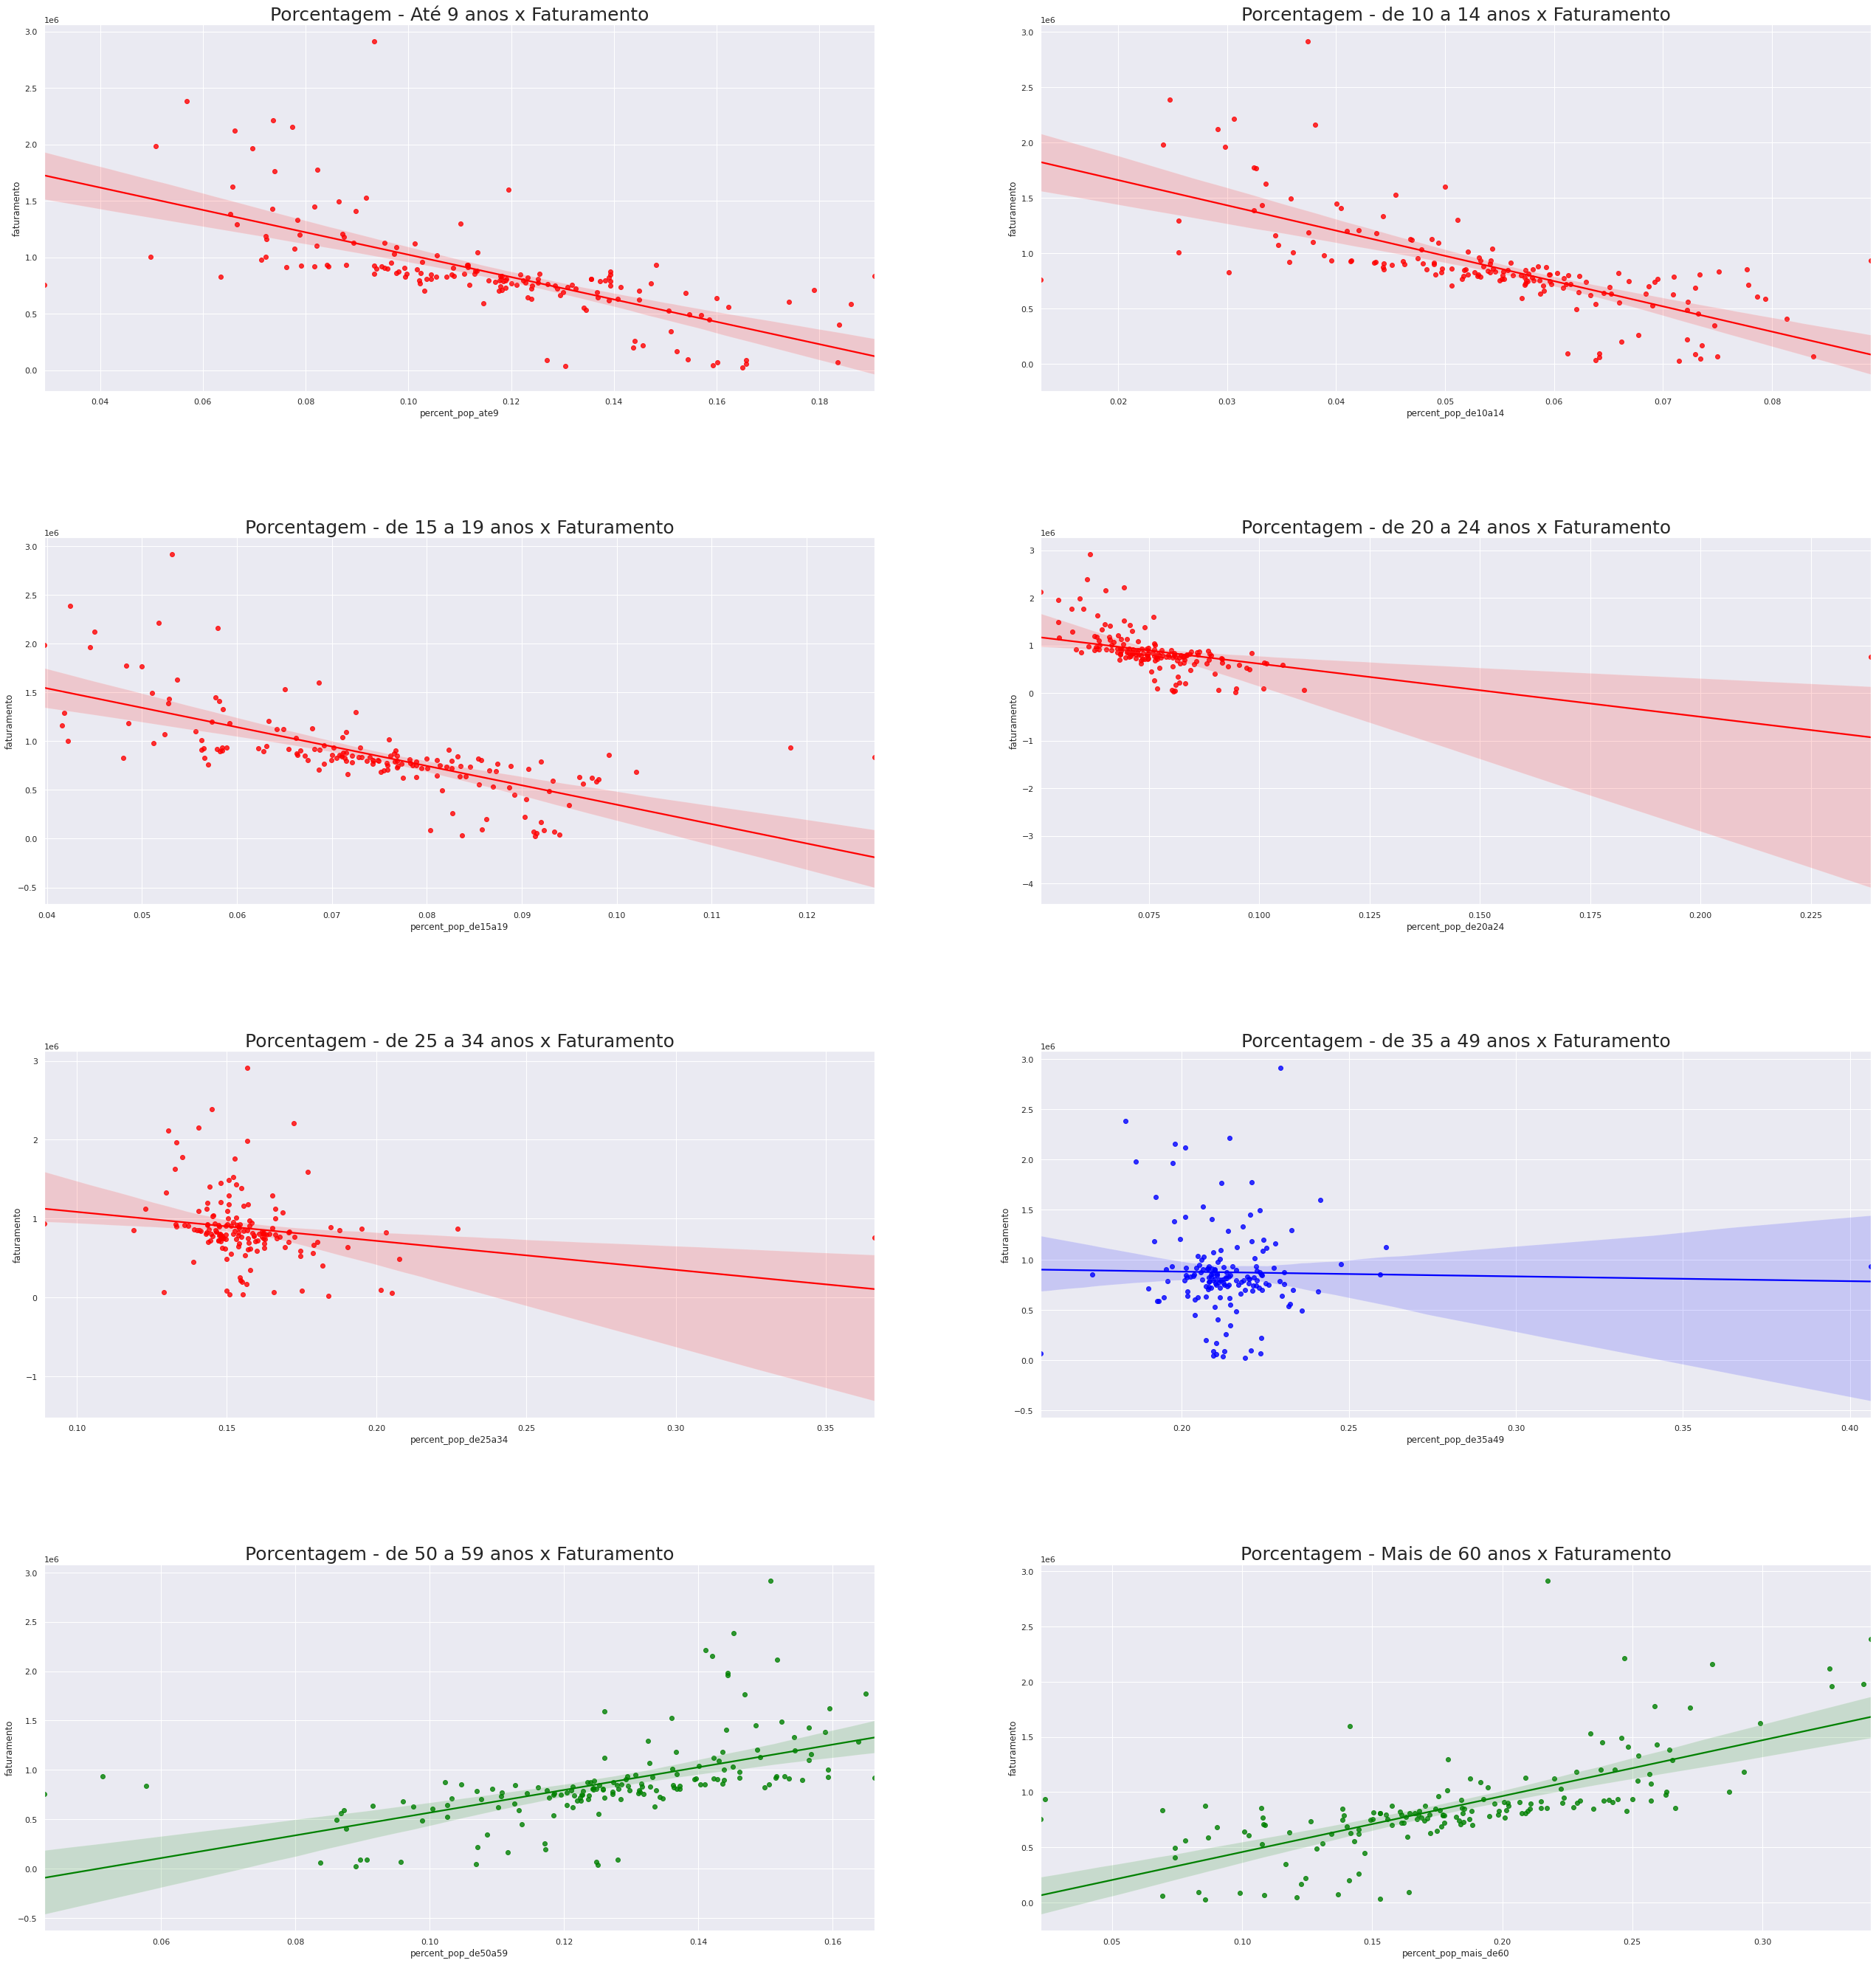

In [59]:
grid = plt.GridSpec(4, 2)

plt.subplot(grid[0, 0])
# Porcentagem - Até 9 anos x Faturamento
sns.regplot(x = df3['percent_pop_ate9'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - Até 9 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[0, 1])
# Porcentagem - de 10 a 14 anos x Faturamento
sns.regplot(x = df3['percent_pop_de10a14'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 10 a 14 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[1, 0])
# Porcentagem - de 15 a 19 anos x Faturamento
sns.regplot(x = df3['percent_pop_de15a19'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 15 a 19 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[1, 1])
# Porcentagem - de 20 a 24 anos x Faturamento
sns.regplot(x = df3['percent_pop_de20a24'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 20 a 24 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[2, 0])
# Porcentagem - de 25 a 34 anos x Faturamento
sns.regplot(x = df3['percent_pop_de25a34'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 25 a 34 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[2, 1])
# Porcentagem - de 35 a 49 anos x Faturamento
sns.regplot(x = df3['percent_pop_de35a49'], y = df3['faturamento'], color='Blue')
plt.title('Porcentagem - de 35 a 49 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[3, 0])
# Porcentagem - de 50 a 59 anos x Faturamento
sns.regplot(x = df3['percent_pop_de50a59'], y = df3['faturamento'], color='green')
plt.title('Porcentagem - de 50 a 59 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[3, 1])
# Porcentagem - Mais de 60 anos x Faturamento
sns.regplot(x = df3['percent_pop_mais_de60'], y = df3['faturamento'], color='green')
plt.title('Porcentagem - Mais de 60 anos x Faturamento', fontdict={'fontsize':25})

# Ajuste subplots
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1.5, 
                    top=3, 
                    wspace=0.2, 
                    hspace=0.40)

### H14. Domicílio Bairro x Faturamento
- Maior Faturamento em bairros com porcentagem de Domicílios A e B superior
- Menor Faturamento em bairros com porcentagem de Domicílios C, D e E superior

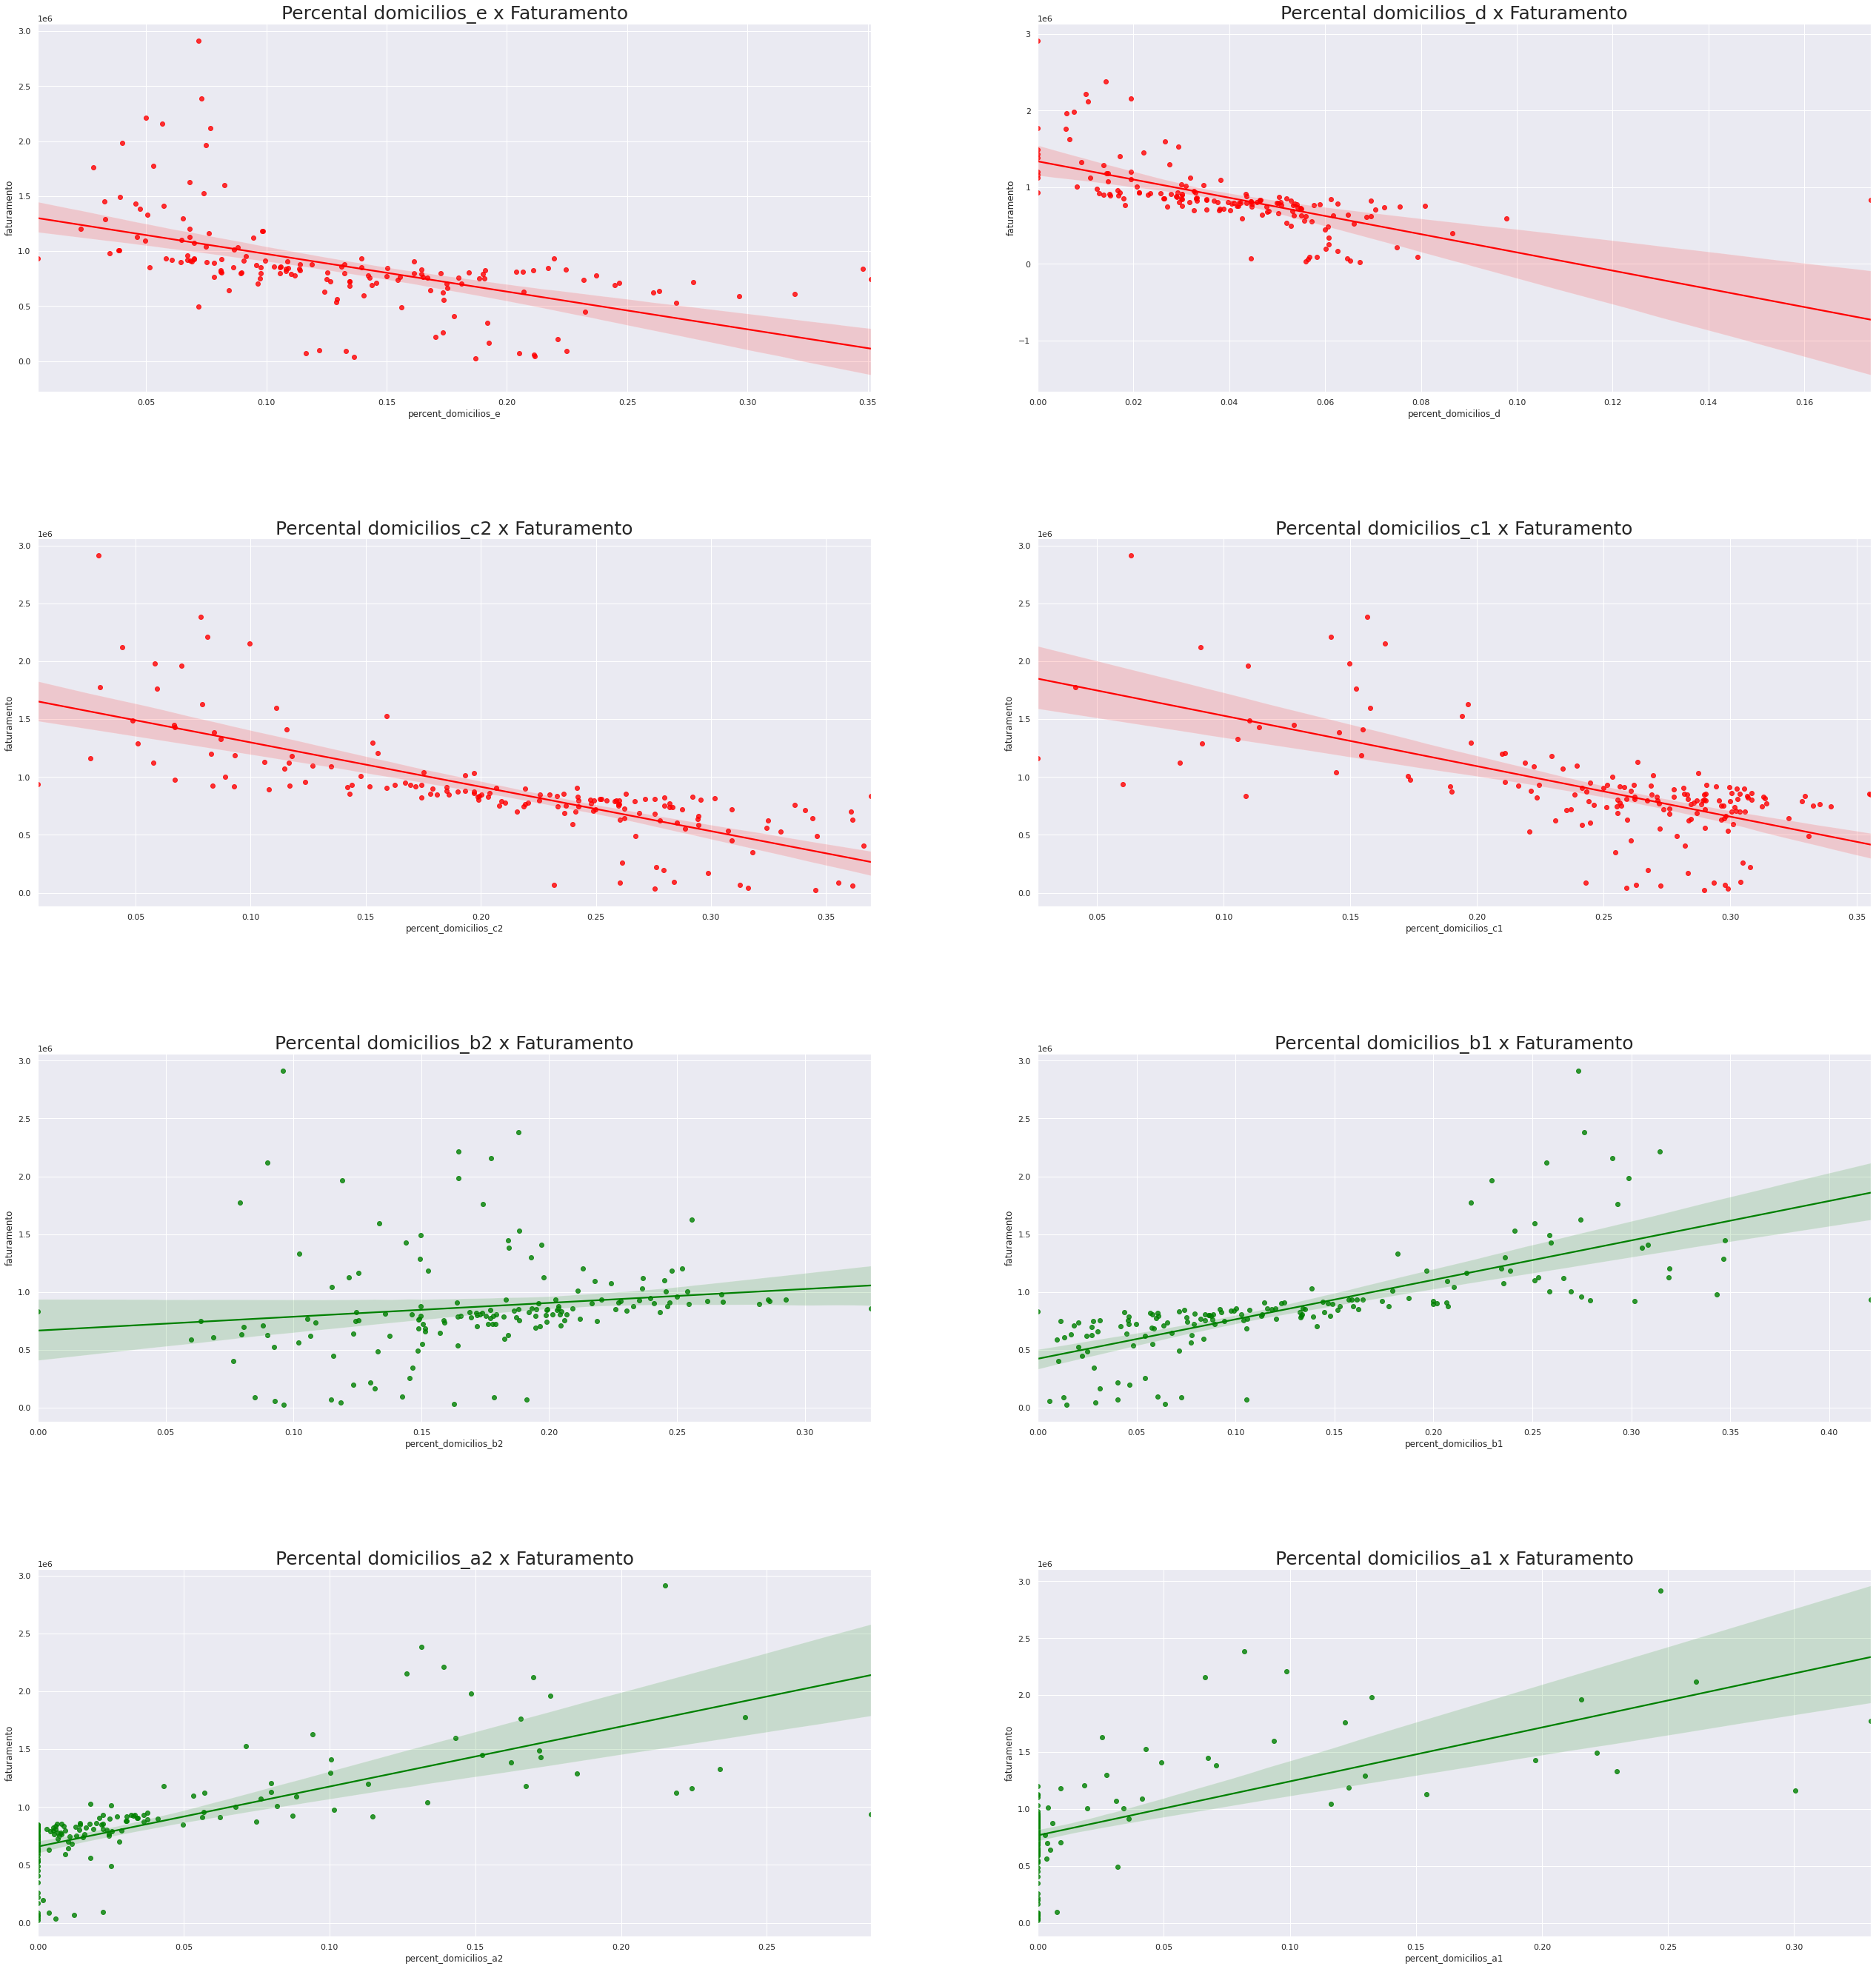

In [60]:
grid = plt.GridSpec(4, 2)

plt.subplot(grid[0, 0])
# Percentual - domicilios_e x Faturamento
sns.regplot(x = df3['percent_domicilios_e'], y = df3['faturamento'], color='red')
plt.title('Percental domicilios_e x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[0, 1])
# Percentual - domicilios_d x Faturamento
sns.regplot(x = df3['percent_domicilios_d'], y = df3['faturamento'], color='red')
plt.title('Percental domicilios_d x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[1, 0])
# Percentual - domicilios_c2 x Faturamento
sns.regplot(x = df3['percent_domicilios_c2'], y = df3['faturamento'], color='red')
plt.title('Percental domicilios_c2 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[1, 1])
# Percentual - domicilios_c1 x Faturamento
sns.regplot(x = df3['percent_domicilios_c1'], y = df3['faturamento'], color='red')
plt.title('Percental domicilios_c1 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[2, 0])
# Percentual - domicilios_b2 x Faturamento
sns.regplot(x = df3['percent_domicilios_b2'], y = df3['faturamento'], color='green')
plt.title('Percental domicilios_b2 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[2, 1])
# Percentual - domicilios_b1 x Faturamento
sns.regplot(x = df3['percent_domicilios_b1'], y = df3['faturamento'], color='green')
plt.title('Percental domicilios_b1 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[3, 0])
# Percentual - domicilios_a2 x Faturamento
sns.regplot(x = df3['percent_domicilios_a2'], y = df3['faturamento'], color='green')
plt.title('Percental domicilios_a2 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[3, 1])
# Percentual - domicilios_a1 x Faturamento
sns.regplot(x = df3['percent_domicilios_a1'], y = df3['faturamento'], color='green')
plt.title('Percental domicilios_a1 x Faturamento', fontdict={'fontsize':25})

# Ajuste subplots
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1.5, 
                    top=3, 
                    wspace=0.2, 
                    hspace=0.40)

### H16. População Absoluta Bairro x Faturamento
- Baixa correlação entre as variáveis

<AxesSubplot:>

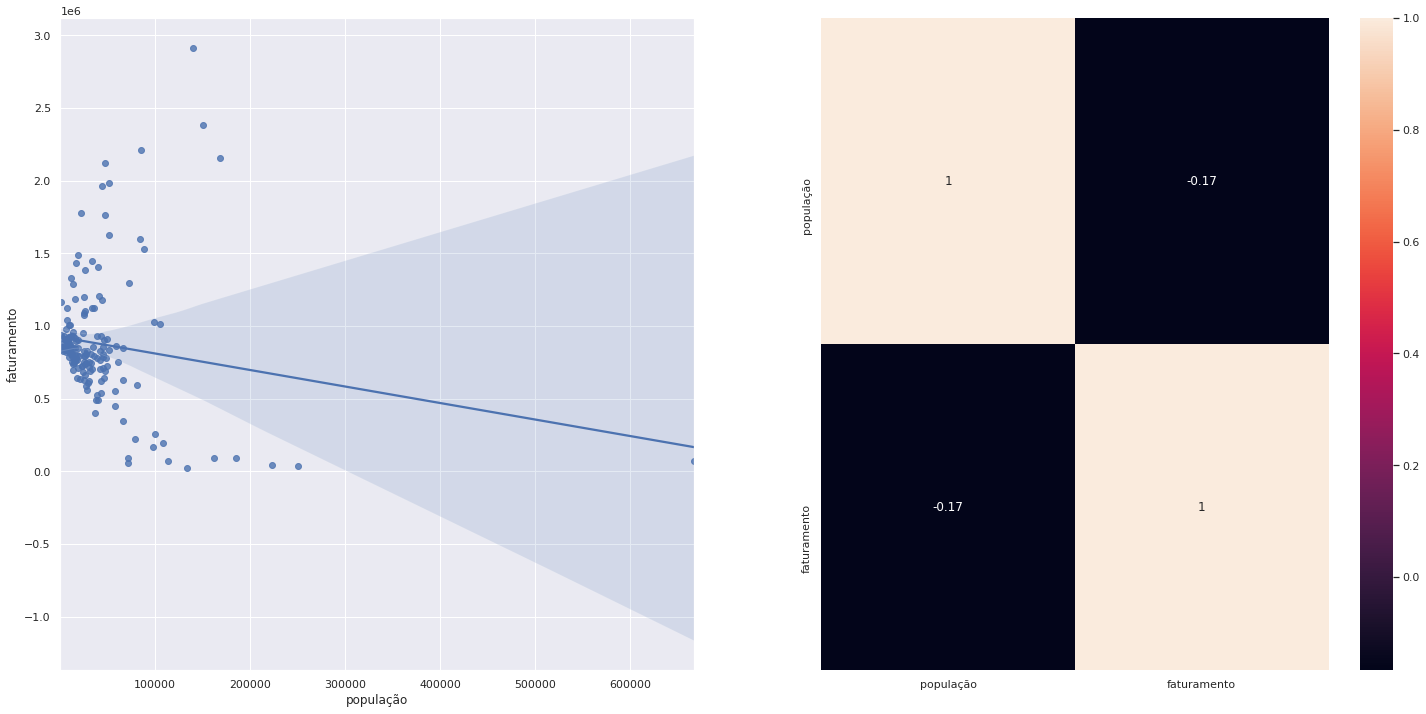

In [61]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
sns.regplot(x='população', y='faturamento', data=df3)

plt.subplot(grid[0, 1])
sns.heatmap(df3[['população', 'faturamento']].corr(method='pearson'), annot=True)

### H17. População Absoluta Subprefeitura x Faturamento
- A correlação entre as variáveis é baixa
- Entretanto, é possível perceber uma pequena tendência de redução de faturamento em subprefeituras mais populosas.

<AxesSubplot:>

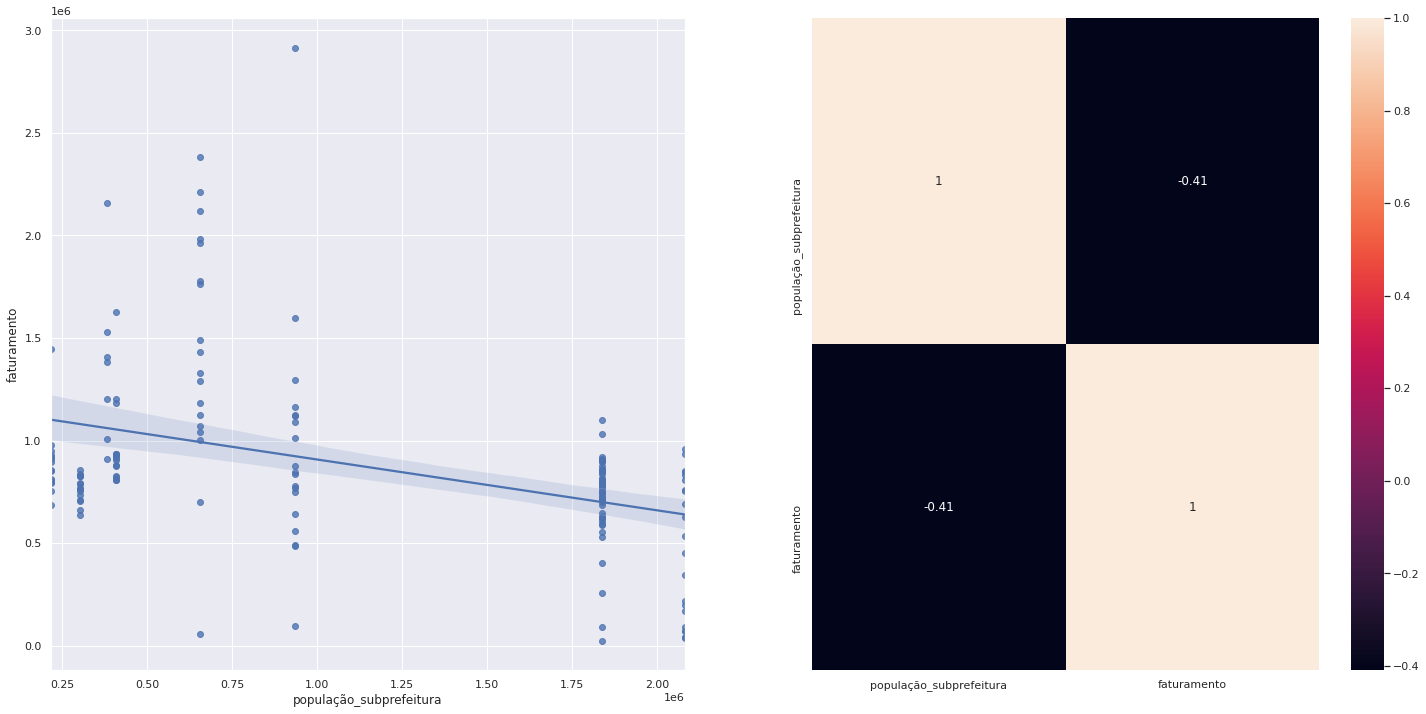

In [62]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
sns.regplot(x='população_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[0, 1])
sns.heatmap(df3[['população_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

## 3.3. Análise Multivariada

In [63]:
num_attributes = df3.select_dtypes(include=['float64', 'int64'])
num_attributes = num_attributes.drop('codigo', axis=1)

### 3.3.1. Atributos Numericos

<AxesSubplot:>

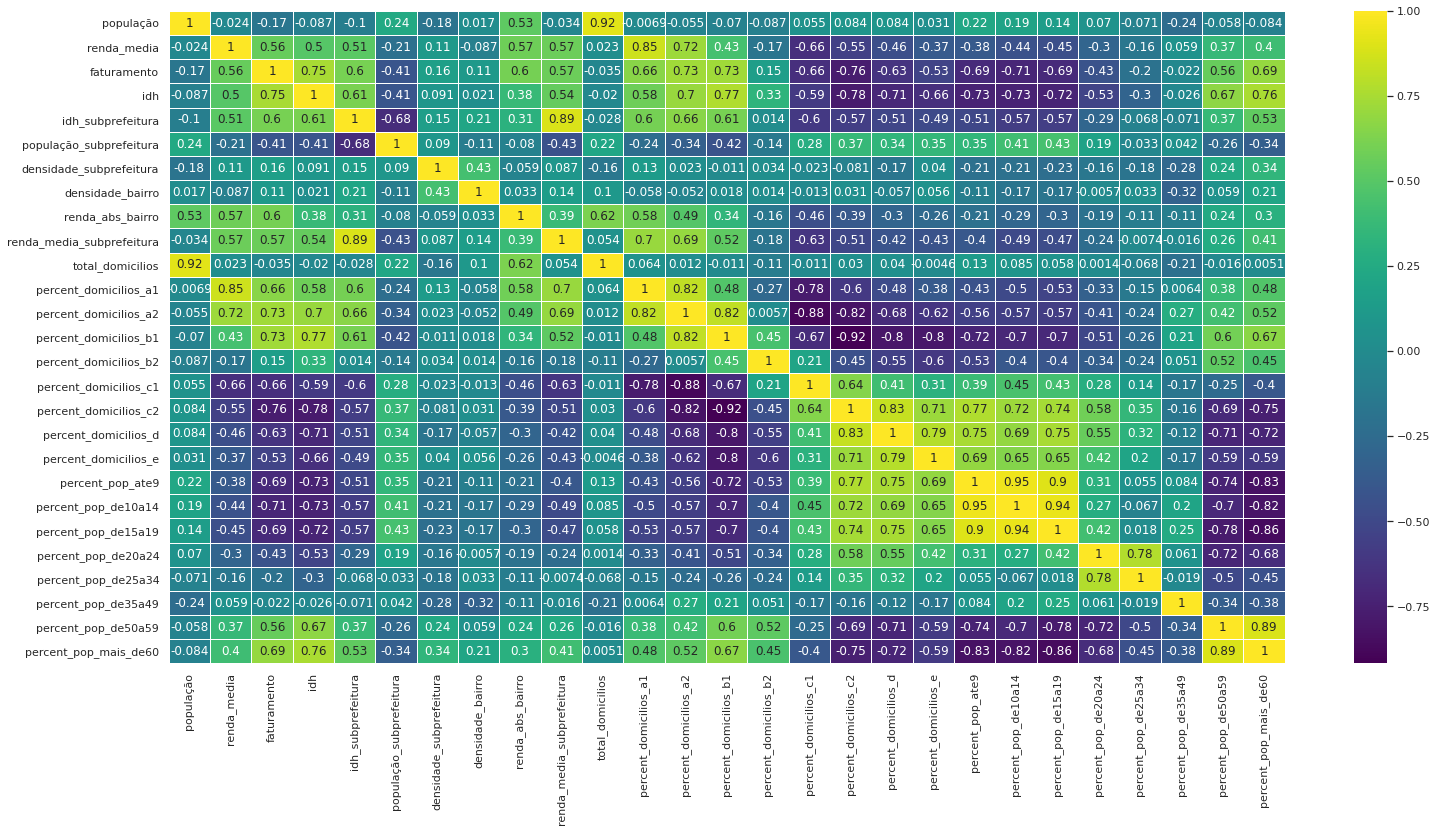

In [64]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, cmap='viridis', linewidths=.5, annot=True)

Correlações Altas -> 

In [65]:
age_att = num_attributes.iloc[:, 20:]

<AxesSubplot:>

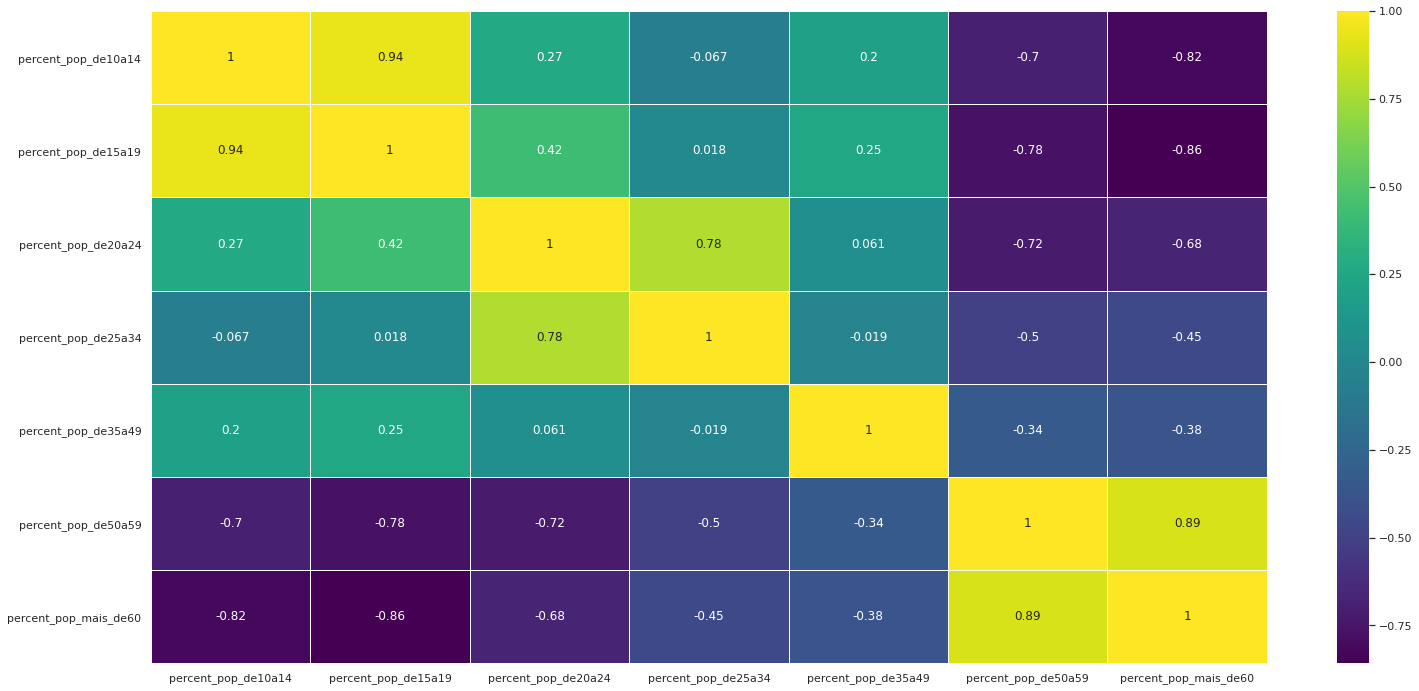

In [66]:
correlation = age_att.corr(method='pearson')
sns.heatmap(correlation, cmap='viridis', linewidths=.5, annot=True)

In [67]:
domic_att = num_attributes.iloc[:, 12:20]

<AxesSubplot:>

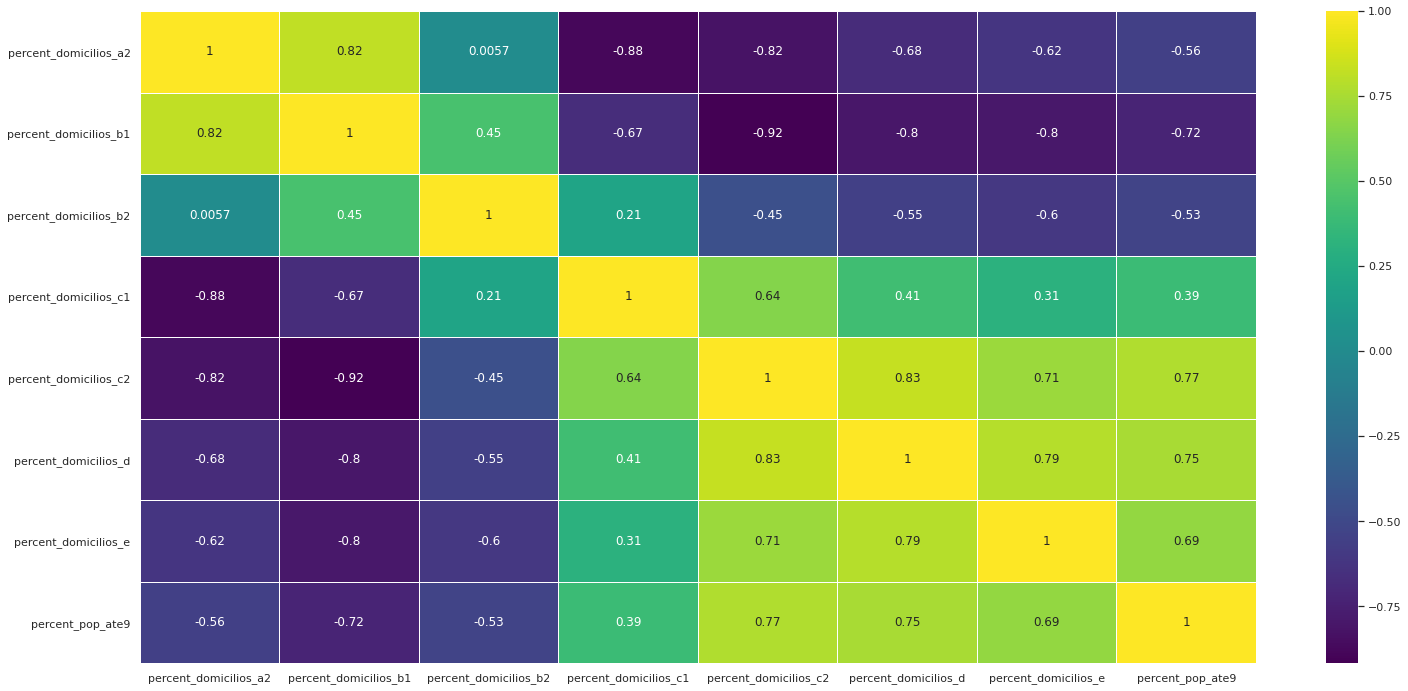

In [68]:
correlation = domic_att.corr(method='pearson')
sns.heatmap(correlation, cmap='viridis', linewidths=.5, annot=True)

## 4.0. Filtragem

In [101]:
df4 = df3.copy()

## 4.1. Colunas

In [102]:
# domicilio A e B
df4['percent_ab'] = (df4['percent_domicilios_a1'] + df4['percent_domicilios_a2'] + 
                     df4['percent_domicilios_b1'] + df4['percent_domicilios_b2'])

# idade
df4['percent_50'] = df4['percent_pop_de50a59'] + df4['percent_pop_mais_de60']

In [103]:
df4 = df4.drop(['codigo', 'nome', 'cidade', 'estado', 'regiao_adm'], axis=1)
             # 'percent_domicilios_a1', 'percent_domicilios_a2','percent_domicilios_b1', 
             # 'percent_domicilios_b2','percent_domicilios_c1', 'percent_domicilios_c2',
             # 'percent_domicilios_d', 'percent_domicilios_e', 'percent_pop_ate9',
             ## 'percent_pop_de10a14', 'percent_pop_de15a19', 'percent_pop_de20a24',
             # 'percent_pop_de25a34', 'percent_pop_de35a49', 'percent_pop_de50a59',
             # 'percent_pop_mais_de60'], axis=1)

## 4.2. Linhas - Analise de Outliers

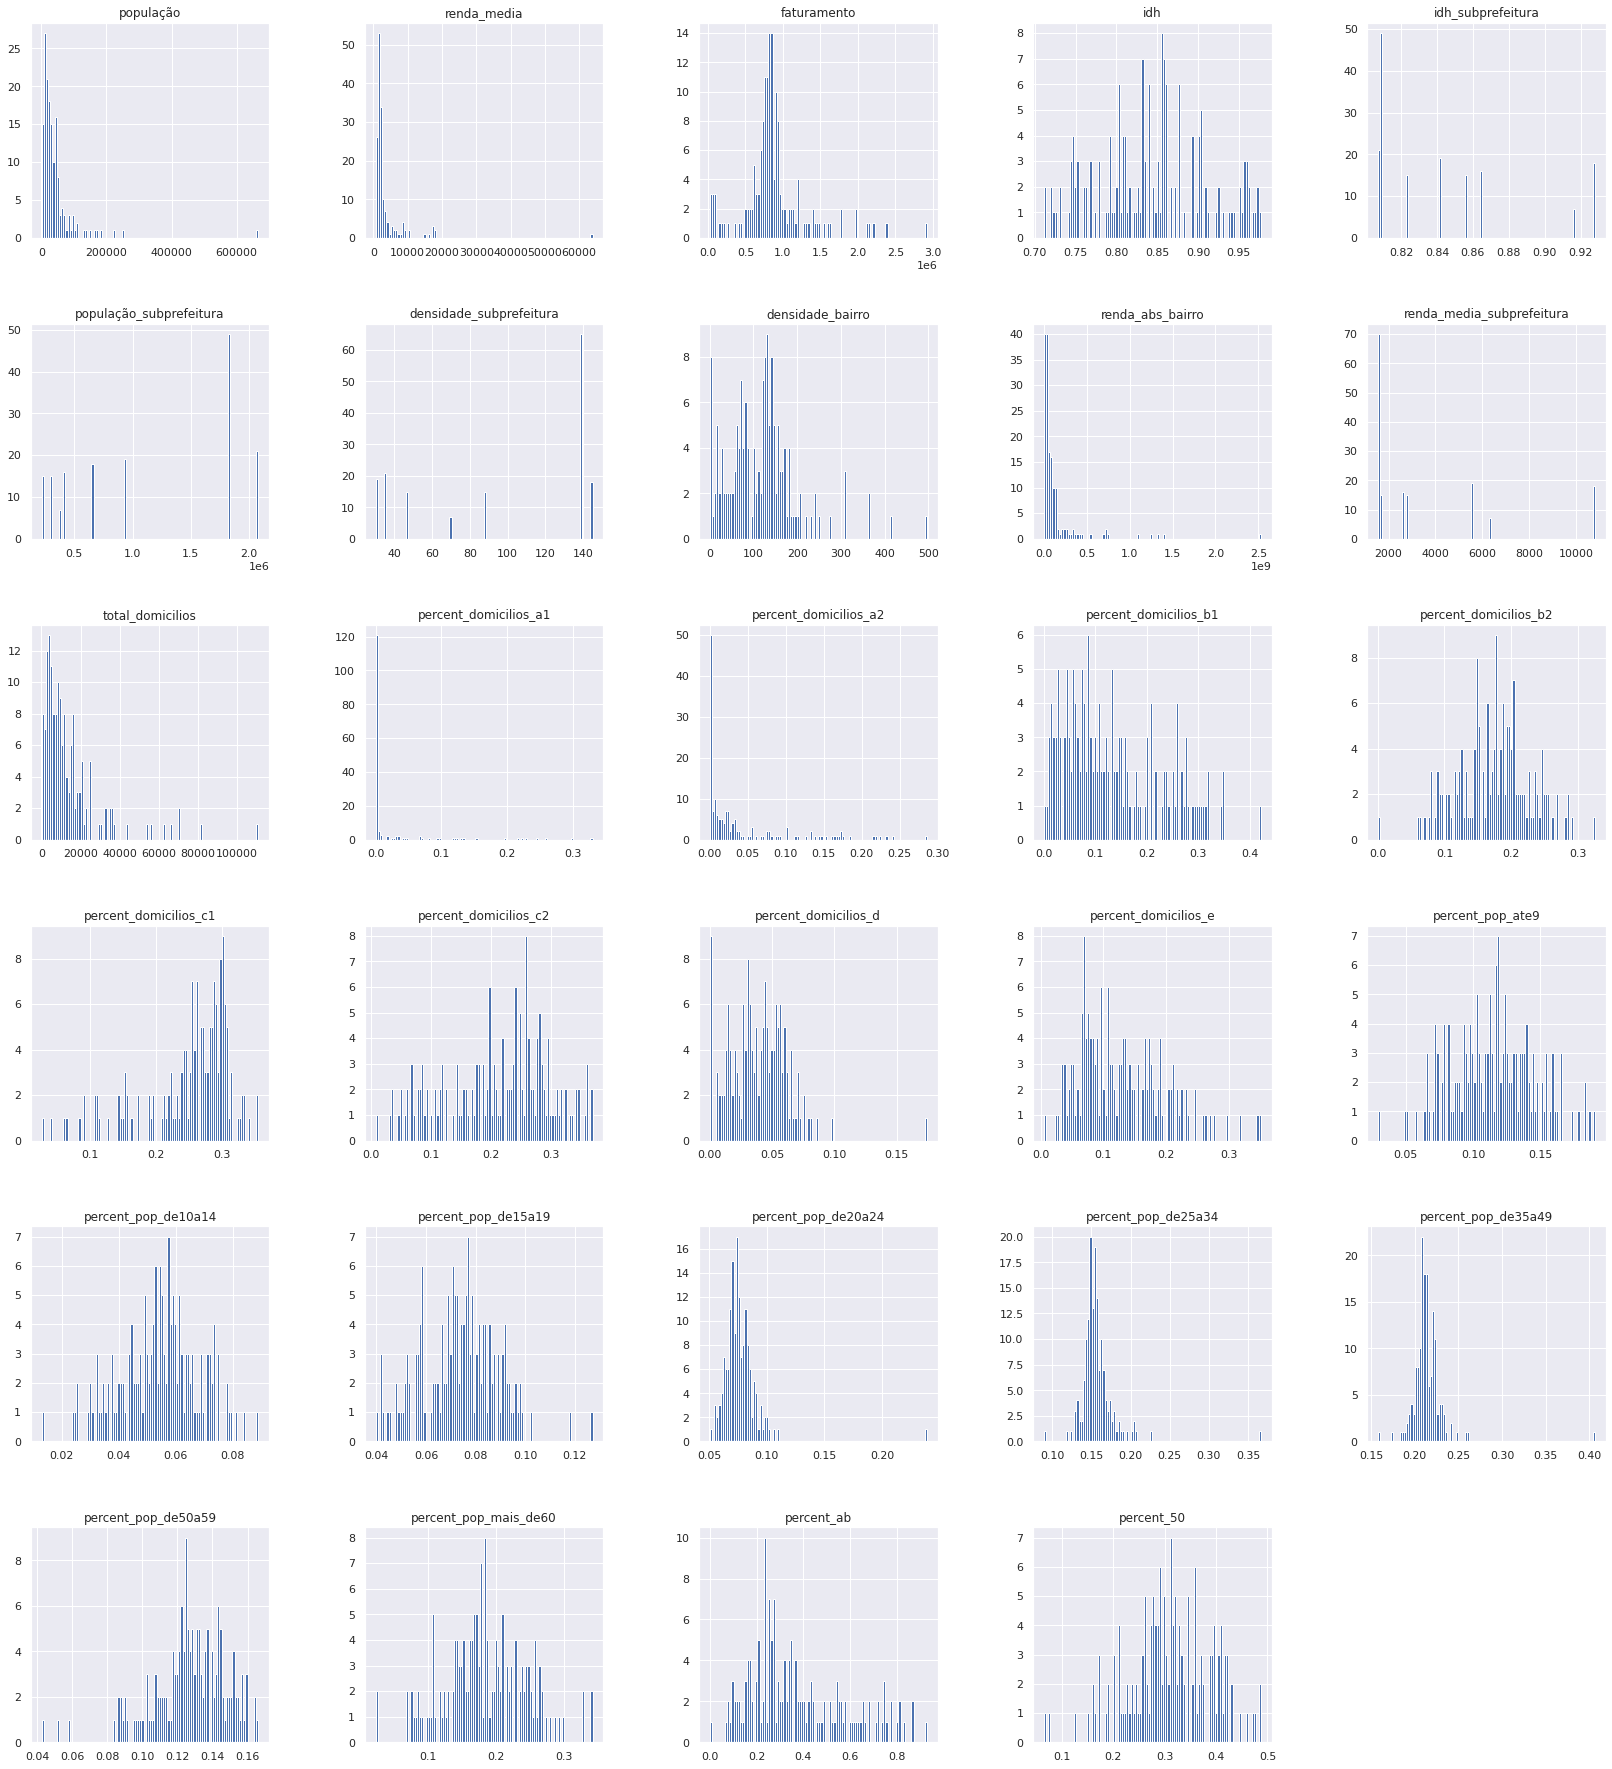

In [104]:
df4.hist(bins=100);
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.40)

Analise
- população
- renda_media
- renda_abs_bairro
- total_domicilios

<AxesSubplot:xlabel='total_domicilios'>

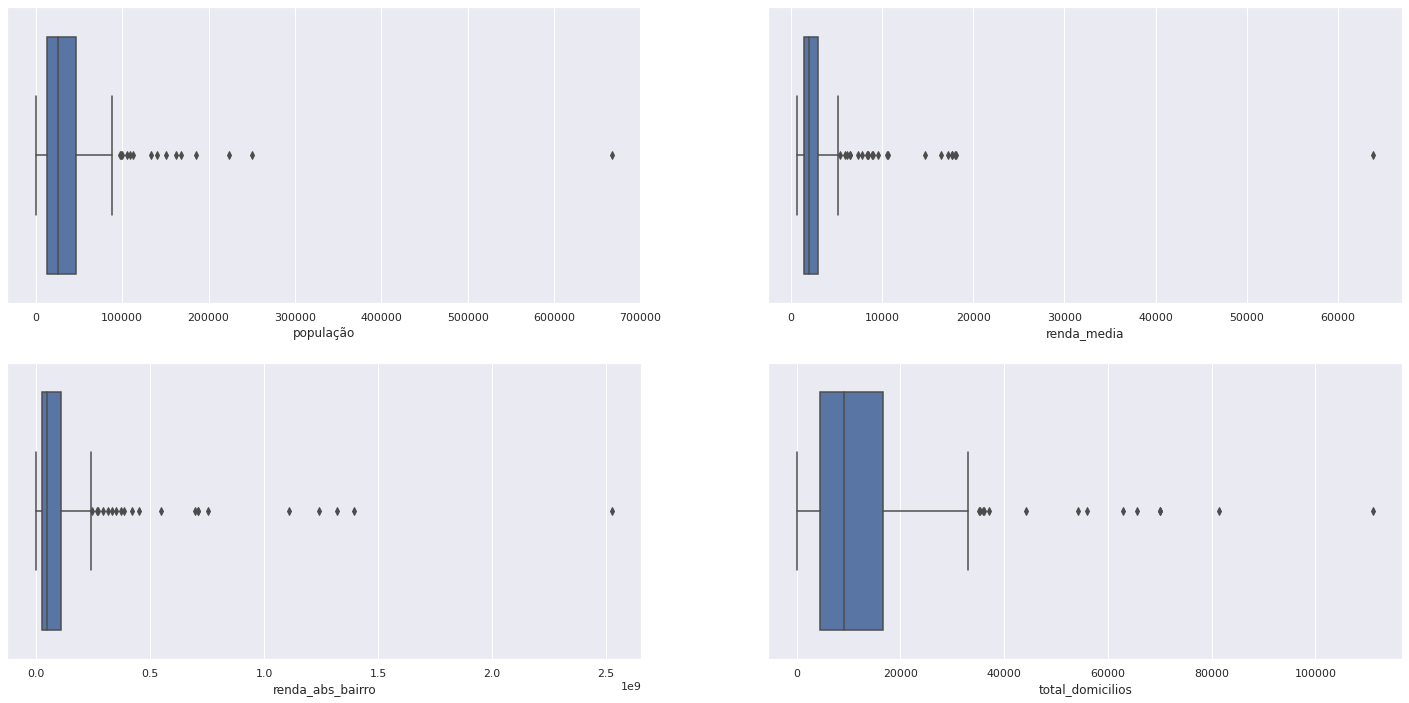

In [105]:
grid = plt.GridSpec(2, 2)

plt.subplot(grid[0, 0])
sns.boxplot(x = df4['população'])

plt.subplot(grid[0, 1])
sns.boxplot(x = df4['renda_media'])

plt.subplot(grid[1, 0])
sns.boxplot(x = df4['renda_abs_bairro'])

plt.subplot(grid[1, 1])
sns.boxplot(x = df4['total_domicilios'])

In [106]:
outlier_pop = df4['população'].quantile([0.75]) + (df4['população'].quantile([0.75]).values - df4['população'].quantile([0.25]).values) * 3.5
outlier_renda_media = df4['renda_media'].quantile([0.75]) + (df4['renda_media'].quantile([0.75]).values - df4['renda_media'].quantile([0.25]).values) * 3.5
outlier_total_domicilios = df4['total_domicilios'].quantile([0.75]) + (df4['total_domicilios'].quantile([0.75]).values - df4['total_domicilios'].quantile([0.25]).values) * 2

In [107]:
outlier_pop

0.750             162500.625
Name: população, dtype: float64

In [108]:
outlier_renda_media

0.750               8252.500
Name: renda_media, dtype: float64

In [109]:
outlier_renda_abs

0.750          282519873.750
Name: renda_abs_bairro, dtype: float64

In [110]:
outlier_total_domicilios

0.750              40621.750
Name: total_domicilios, dtype: float64

In [111]:
drop_rows = df4.loc[(df4['população'] > outlier_pop.values[0]) |
                    (df4['renda_media'] > outlier_renda_media.values[0]) |
                    (df4['total_domicilios'] > outlier_total_domicilios.values[0]), :]

In [112]:
percent = round(drop_rows.shape[0] / df4.shape[0], 2) * 100

In [113]:
print(f'{percent}% das linhas serão excluidas.')

15.0% das linhas serão excluidas.


In [114]:
df4 = df4.drop(drop_rows.index, axis=0)

<AxesSubplot:xlabel='total_domicilios'>

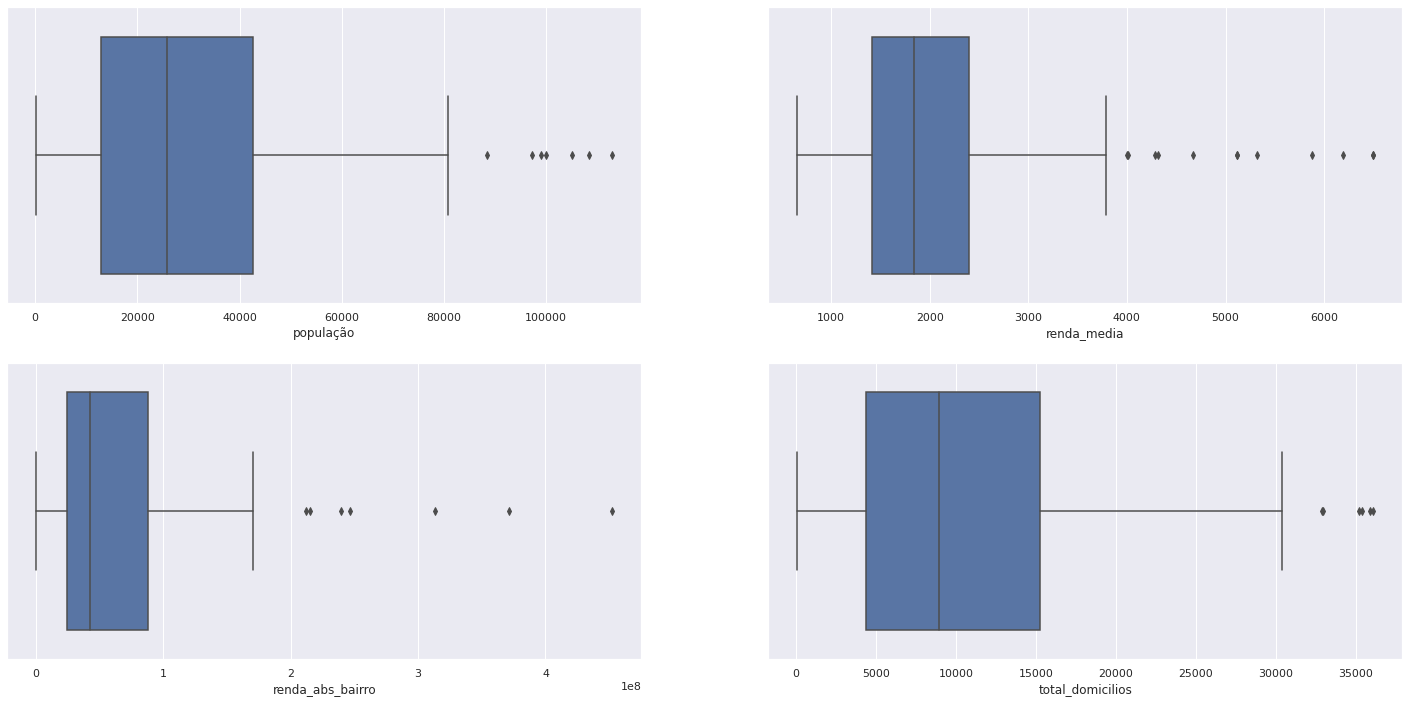

In [115]:
grid = plt.GridSpec(2, 2)

plt.subplot(grid[0, 0])
sns.boxplot(x = df4['população'])

plt.subplot(grid[0, 1])
sns.boxplot(x = df4['renda_media'])

plt.subplot(grid[1, 0])
sns.boxplot(x = df4['renda_abs_bairro'])

plt.subplot(grid[1, 1])
sns.boxplot(x = df4['total_domicilios'])

## 5.0. Tratamento

In [116]:
df5 = df4.copy()

## 5.1. Separacao de Variaveis

In [117]:
X = df5.drop('faturamento', axis=1)

y = df5.loc[:, 'faturamento']

## 5.2. Encoding

In [118]:
# Subprefeitura -> ohe
ohe = pd.get_dummies(X['subprefeitura'])
X = pd.merge(X, ohe, how='inner', left_index=True, right_index=True)
X = X.drop('subprefeitura', axis=1)

## 5.3. Split em Treino e Teste

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

## 5.4. Normalizacao da Variavel Resposta

In [120]:
# Transformando em log
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
y = np.log1p(y)

# 6.0. Feature Selection

In [121]:
X_feat = X_train.copy()

## 6.1. Normalizando os Dados

In [122]:
list_columns = ['população', 'renda_media', 'idh', 'idh_subprefeitura',
       'população_subprefeitura', 'densidade_subprefeitura',
       'densidade_bairro', 'renda_abs_bairro', 'renda_media_subprefeitura',
       'total_domicilios', 'percent_domicilios_a1', 'percent_domicilios_a2',
       'percent_domicilios_b1', 'percent_domicilios_b2',
       'percent_domicilios_c1', 'percent_domicilios_c2',
       'percent_domicilios_d', 'percent_domicilios_e', 'percent_pop_ate9',
       'percent_pop_de10a14', 'percent_pop_de15a19', 'percent_pop_de20a24',
       'percent_pop_de25a34', 'percent_pop_de35a49', 'percent_pop_de50a59',
       'percent_pop_mais_de60', 'percent_ab', 'percent_50',
       'Barra e Jacarepaguá', 'Centro e Centro Histórico', 'Grande Méier',
       'Grande Tijuca', 'Ilha do Governador', 'Zona Norte', 'Zona Oeste',
       'Zona Sul']

scaler = MinMaxScaler()
for value in list_columns:
    scaled = scaler.fit_transform(X_feat[[value]].values)
    X_feat[value] = scaled

## 6.2. Feature Selection Boruta

In [123]:
# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=32).fit(X_feat.values, y_train.values)

In [124]:
cols_selected = boruta.support_.tolist()

In [125]:
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['população',
 'idh',
 'densidade_bairro',
 'total_domicilios',
 'percent_pop_ate9',
 'percent_pop_de20a24',
 'percent_ab']

## 6.3. Feature Selection Manual

<AxesSubplot:>

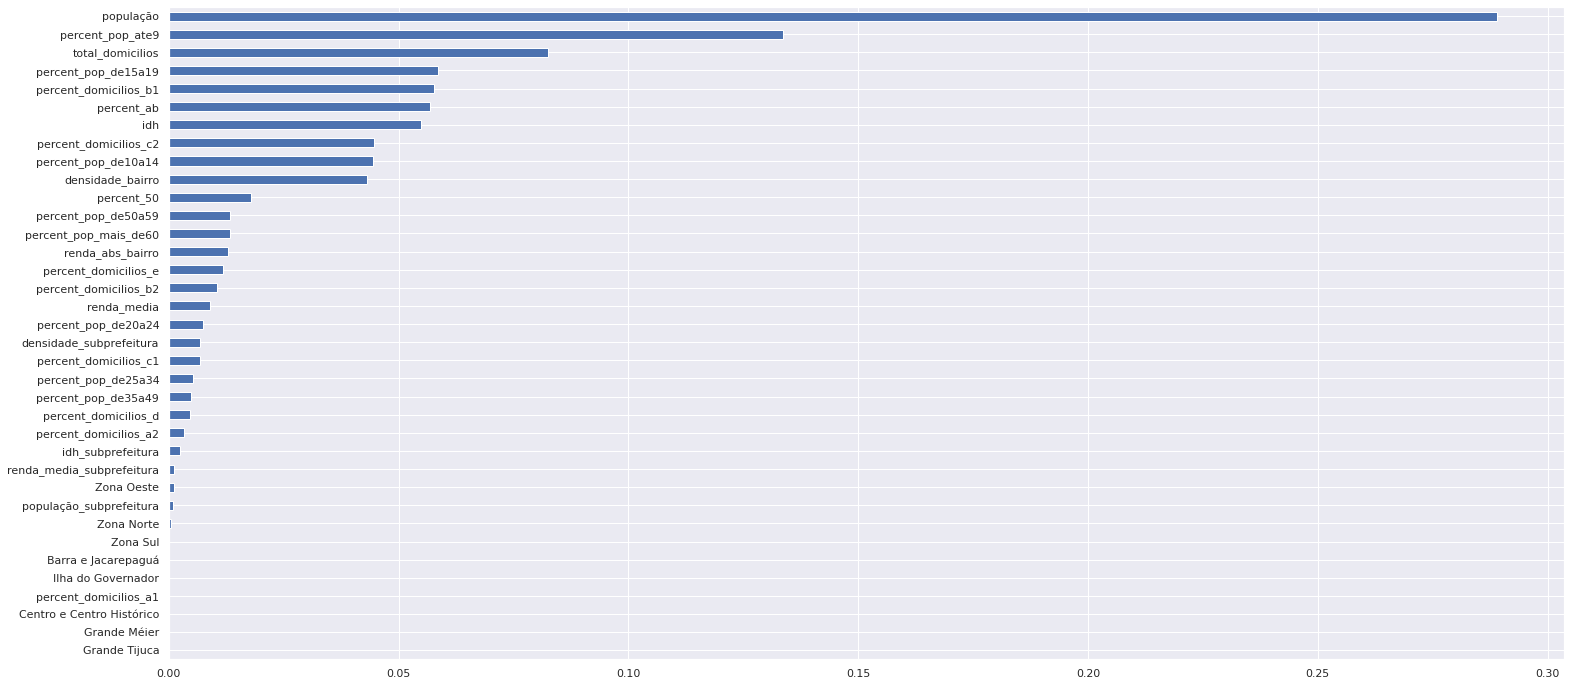

In [443]:
#feature importances 
rf_model = RandomForestRegressor()
rf_model.fit(X_feat, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')

## 6.4. Recursive Feature Elimination (RFE)

In [444]:
from sklearn.feature_selection import RFE

In [447]:
rfe = RFE(estimator=rf_model, n_features_to_select=8)
fit = rfe.fit(X_feat, y_train)

In [448]:
for i in range(X.shape[1]):
    print('{} - Rank: {}'.format(X.columns[i], rfe.ranking_[i]))

população - Rank: 1
renda_media - Rank: 9
idh - Rank: 1
idh_subprefeitura - Rank: 15
população_subprefeitura - Rank: 20
densidade_subprefeitura - Rank: 19
densidade_bairro - Rank: 1
renda_abs_bairro - Rank: 5
renda_media_subprefeitura - Rank: 18
total_domicilios - Rank: 1
percent_domicilios_a1 - Rank: 24
percent_domicilios_a2 - Rank: 16
percent_domicilios_b1 - Rank: 4
percent_domicilios_b2 - Rank: 12
percent_domicilios_c1 - Rank: 13
percent_domicilios_c2 - Rank: 2
percent_domicilios_d - Rank: 7
percent_domicilios_e - Rank: 11
percent_pop_ate9 - Rank: 1
percent_pop_de10a14 - Rank: 1
percent_pop_de15a19 - Rank: 1
percent_pop_de20a24 - Rank: 6
percent_pop_de25a34 - Rank: 8
percent_pop_de35a49 - Rank: 17
percent_pop_de50a59 - Rank: 14
percent_pop_mais_de60 - Rank: 3
percent_ab - Rank: 1
percent_50 - Rank: 10
Barra e Jacarepaguá - Rank: 28
Centro e Centro Histórico - Rank: 25
Grande Méier - Rank: 27
Grande Tijuca - Rank: 29
Ilha do Governador - Rank: 23
Zona Norte - Rank: 22
Zona Oeste - Ra

## 6.5. Lista Final de Features

In [126]:
features = ['idh', 'total_domicilios', 'percent_pop_ate9', 'percent_pop_de10a14',
            'percent_ab', 'densidade_bairro', 'percent_pop_mais_de60']

X_train = X_train[features]
X_test = X_test[features]
X = X[features]

## 7.0. Modelagem de Machine Learning

## 7.1. Average Model - Baseline

In [176]:
model_bl = ml_performance(X_train, y_train, folds=10, baseline=True)
model_bl

,Model Name,MAE,MAPE,R2
0,AverageModel,167664.669,0.454,-0.309



## 7.2. LinearRegresion

In [177]:
model_lr = ml_performance(X_train, y_train, lm.LinearRegression(), folds=10)
model_lr

,Model Name,MAE,MAPE,R2
0,LinearRegression,265538.779 +/- 55917.041,0.41 +/- 0.143,-4.885 +/- 8.633


## 7.3. DecisionTreeRegressor

In [178]:
model_dt = ml_performance(X_train, y_train, tr.DecisionTreeRegressor(random_state=32), folds=10)
model_dt

,Model Name,MAE,MAPE,R2
0,DecisionTreeRegressor,180787.163 +/- 73521.408,0.267 +/- 0.106,-2.328 +/- 4.777


## 7.4. Comparacao

In [179]:
pd.concat([model_bl, model_lr, model_dt])

,Model Name,MAE,MAPE,R2
0,AverageModel,167664.669,0.454,-0.309
0,LinearRegression,265538.779 +/- 55917.041,0.41 +/- 0.143,-4.885 +/- 8.633
0,DecisionTreeRegressor,180787.163 +/- 73521.408,0.267 +/- 0.106,-2.328 +/- 4.777


Utilizando o MAPE como métrica de escolha, o modelo que performou melhor foi o DecisionTreeRegressor. Ele será escolhido como modelo final.

# 8.0. Otimizacao de Hiperparametros

In [180]:
# Possiveis parametros
param = {
    'min_split': [2, 3, 4, 5, 6, 7],
    'max_nivel': [3, 4, 5, 6, 7, 9, 11],
    'criterion' : ['mse', 'friedman_mse', 'mae']
        }


MAX_EVAL = 100

In [181]:
#dict_iter = {}
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample( v, 1 )[0] for k, v in param.items()}
#    
#    # model
#    model_tr = tr.DecisionTreeRegressor(criterion=hp['criterion'],
#                                 max_depth=hp['max_nivel'], 
#                                 min_samples_split=hp['min_split'],
#                                 random_state=32) 
#
#    
#    model_dt = ml_performance(X_train, y_train, model_tr, mape_eval=True)
#    
#    dict_iter[model_dt] = hp

In [182]:
#df = pd.DataFrame(dict_iter).T.reset_index().sort_values(by='index')
#df.iloc[0, :]

# 9.0. Avaliacao

## 9.1. Test Data

In [183]:
scaler = MinMaxScaler()
X_train_scal = X_train.copy()
X_test_scal = X_test.copy()
for value in X_train.columns:
    scaled_train = scaler.fit_transform(X_train[[value]].values)
    X_train_scal.loc[:, value] = scaled_train.copy()
            
    scaled_test = scaler.fit_transform(X_test[[value]].values)
    X_test_scal[value] = scaled_test

In [196]:
model_final = tr.DecisionTreeRegressor(min_samples_split = 2, max_depth = 3, random_state=32)

with open('/home/tcbm/projs/case_geofusion/model/model_faturamento.pkl', 'wb') as file:
    pickle.dump(model_final, file)

In [194]:
model_final.fit(X_train_scal, y_train)

DecisionTreeRegressor(max_depth=3, random_state=32)

In [186]:
yhat = model_final.predict(X_test_scal)

In [187]:
mean_absolute_percentage_error(np.expm1(y_test), np.expm1(yhat))

0.18883169615313078

## 9.2. CrossValidation em todos os dados

In [188]:
ml_performance(X, y, model_final, baseline=False, )

,Model Name,MAE,MAPE,R2
0,DecisionTreeRegressor,139240.089 +/- 64829.436,0.211 +/- 0.12,0.08 +/- 0.962
